# Project 2 - Numerical Methods of analysis

Univeristy ID: 11018744\
University of Manchester\
March 2024

This program investigates four different numerical integration methods and determines their accuracy by comparing them to an analytical method, using a damped mass-spring system with equation of motion: $ma+bv+kx=0$.

It then uses the best numerical method to investigate the effect of an external force on the system, with a modified equation of motion: $ma+bv+kx=F(t)$.

Finally, the best numerical method is again used to investigate resonance in a forced oscillation system by looking at how the amplitude of oscillations vary with the frequency of the external oscillations.

### Initialising code

In [1]:
# Initialisation
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

Inputting my specific variable values, $k$ = spring constant, $m$ = mass, $b$ = damping constant, $h$ = time step, and setting other parameters including initial conditions.

In [2]:
k = 1.27    # kg/s^2
m = 4.03    # kg
b_values = [0.00, 0.01, 0.04, 0.5, 1]    # kg/s
h_values = [10, 1, 0.1, 0.05, 0.005, 0.0005]   # s

# Choose how long to run the model (integrate) for
T = 150

# Set initial conditions
x0 = 0
v0 = -1

## Analytic solution

The analytic solution is needed to be able to compare the numerical methods to in order to assess their accuracy. It is defined according to the equations:

$A = \left( \frac{b}{2i\sqrt{4km-b^2}} + \frac{1}{2} \right)\cdot x_0 + \frac{v_0m}{\sqrt{4km-b^2}\cdot i}$ \
$B = x_0 - A$ \
$x = \exp\left(\frac{-bt}{2m}\right) \left( A\exp\left(\frac{i\sqrt{4km-b^2}t}{2m}\right) \right) + B\exp\left(\frac{-i\sqrt{4km-b^2}t}{2m}\right)$

In [3]:
# The analytic solution when b is not b_cr
def Analytic(x0, v0, b, time):
    # Constants
    A = (b/(2*1j*cmath.sqrt(4*k*m-b**2))+1/2)*x0+v0*m/(cmath.sqrt(4*k*m-b**2)*1j) 
    B = x0-A
    
    X = np.exp(-b*time/(2*m))*(A*np.exp(1j*cmath.sqrt(4*k*m-b**2)*time/(2*m))
                              +B*np.exp(-1j*cmath.sqrt(4*k*m-b**2)*time/(2*m)))

    return X

## Euler's Method

Initially, we have $F(t)=0$ for a damped but freely oscillating system.

Numerical integration methods work on the principle that a function can be approximated by the sum of its integrals. The integral changes slightly after each time step, and summing over these changes in integral represents the actual, analytical function plus an error. $\color{red}{\text{**}}$ This means that the next position of the mass-spring system can be predicted based on its current position and velocity, and similarly the velocity at the next time step can be calculated from its current velocity and acceleration:

$x(t + h) = x(t) + h\frac{dx}{dt} = x(t) + hv(t)$ , \
$v(t+h) = v(t) + h\frac{dv}{dt} = v(t) + ha(t)$ .

These two equations, along with the equation for acceleration (found from rearranging the equation of motion for the unforced system): 

$a(t)=\frac{-k}{m}x(t)+\frac{-b}{m}v(t)$ ,

yield the first numerical method, Euler's method.

The algorithmic form of the Euler equations that will be used in the code are:\
$x_{i+1}=x_i+hv_i$ \
$v_{i+1}=v_i+ha_i$ \
$a_i=\frac{-k}{m}x_i+\frac{-b}{m}v_i$

In [4]:
# Function that takes initial conditions and performs Euler integration
def EulerMethod(x0, v0, nsteps, hstep, b):
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0

    for i in range(nsteps-1):

        # Calculate the acceleration at step i (in m/s)
        # No array of these is made, as we don't need to remember them all
        a = -(k/m)*x[i] - (b/m)*v[i]
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i]*hstep
        v[i+1] = v[i] + a*hstep
        
    return (x, v) 

## Improved Euler method

Euler's method is an approximation, and the order of magnitude of the error which it produces can be found by looking at the Taylor expansion of the position equation:

$x(t+h) = x(t) + hx'(t) + \frac{1}{2}h^2x''(\zeta))$, where $t < \zeta < t + h$.

Rearranging this for $v(t) = x'(t)$ shows that the Euler method approximates velocity as:

$v(t) = \frac{x(t+h) - x(t)}{h} + \frac{1}{2}hx''(\zeta)$, 

so $\frac{1}{2}hx''(\zeta)$ is the local truncation error $\mathcal{O}(h)$, which is on the order of $h$. Euler's method can be improved by reducing this error from integration, by extending the Taylor expansion for the position to:

$x(t+h) = x(t) + hx'(t) + \frac{1}{2}h^2x''(t) + error$, thereby giving the error on the order of $h^2$, which for small $h < 1$ will be smaller than Euler's method.

Therefore, the improved Euler algorithm equations are:\
$x_{i+1}=x_i+hv_i+\frac{h^2}{2}a_i$ \
$v_{i+1}=v_i+ha_i$ \
$a_i=\frac{-k}{m}x_i+\frac{-b}{m}v_i$

In [5]:
# Function that takes initial conditions and performs Improved Euler integration
def ImprovedEulerMethod(x0, v0, nsteps, hstep, b):
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0 
    v[0] = v0

    for i in range(nsteps-1):

        # Calculate the acceleration at step i (in m/s)
        a = -(k/m)*x[i] - (b/m)*v[i]
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i]*hstep + ((hstep**2 / 2) * a)
        v[i+1] = v[i] + a*hstep
        
    return (x, v) 

## Verlet Method

Verlet's method uses centred integration: $x'(t) = \lim_{h \to 0}\frac{x(t+h) - x(t-h)}{2h}$ .

As such, two Taylor expansions are needed, one each for $x(t+h)$ and $x(t-h)$:

$x(t+h) = x(t) + hx'(t) + \frac{1}{2}h^2x''(t) + \frac{1}{6}h^3x'''(\zeta)$, \
$x(t-h) = x(t) - hx'(t) + \frac{1}{2}h^2x''(t) - \frac{1}{6}h^3x'''(\zeta)$, \
$t-h < \zeta < t+h$ .

Combining and rearranging these two equation allows the velocity and acceleration algorithm equations to be found and their errors:

$v_i = \frac{x_{t+i} - x_{t_i}}{2h} + \mathcal{O}(h^2)$, \
$a_i = \frac{x_{t+i} + x_{t_i} - 2x_i}{h^2} + \mathcal{O}(h^2)$ .

The second equation can be rearranged to obtain the position algorithm equation with its error, with the velocity and acceleration equations specific to the mass-spring system restated below it:

$x_{i+1} = 2x_i - x_{i-1} + h^2a_i + O(h^4)$, \
$a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i$, \
$v_i = \frac{x_{i+1} - x_{i-1}}{2h}$ .

This shows that the position equation has a much lower error magnitude than the Euler and Improved Euler methods. To get $x_{i+1}$ entirely in terms of $x_i$ $x_{i-1}$, substitute the last $a_i$ and $v_i$ equations into $x_{i+1}$ to get:

$x_{i+1} = Ax_i + Bx_{i-1}$, where $A = \frac{2m-kh^2}{D}$, $B = \frac{bh-2m}{D}$, and $D = 2m + bh$.

In [6]:
def VerletMethod(x0, v0, nsteps, hstep, b):
    # Find x0 and x1 using Euler method, hence input '2' for nsteps to only find first 2 values
    initial_xs = ImprovedEulerMethod(x0, v0, 2, hstep, b)[0] 
    initial_vs = ImprovedEulerMethod(x0, v0, 2, hstep, b)[1] 

    # Create empty arrays ready for the values of x and v
    x_array = np.zeros(nsteps)
    v_array = np.zeros(nsteps)
    
    # Assign initial conditions
    x_array[0] = initial_xs[0]
    x_array[1] = initial_xs[1]
    x_prev = initial_xs[0]
    x = initial_xs[1]
    
    v_array[0] = initial_vs[0]
    v_array[1] = initial_vs[1]
    
    # Setting A, B & D coefficients
    D = (2*m) + (b*hstep)
    A = 2 * ((2*m) - (k*(hstep**2))) / D
    B = ((b*hstep) - (2*m)) / D
    
    for i in range(2, nsteps):
        # For each configuration at step i, calculate x (in m)
        x_temp = x
        x = A*x + B*x_prev   # calculates the next x = x_{i+1}
        x_array[i] = x       # updates the x_array for this next x value.
        x_prev = x_temp
    
        x_next = A*x + B*x_prev # calculates x_{i+2} to use in calculating v_{i+1}, so the x_array and v_array 
                                  # will have the same length and be updating the same index. 
        v = (x_next - x_prev) / (2*hstep) # calculates v_{i+1}
        v_array[i] = v       # updates the v_array for this next v value, for same index as the x value.
        
        
    return x_array, v_array

## Euler-Cromer Method

As will be demonstrated later in the report, the Euler method does not conserve energy and as such is called "non-symplectic". This is because for a system with zero damping, the velocity algorithm equation becomes:

$v_{i+1} = x_i - \frac{hk}{m}x_i$,

and substituting this and the $x_{i+1}$ equation into the equation for energy, 

$E_{i+1} = \frac{1}{2}kx_{i+1}^2 + \frac{1}{2}mv_{i+1}^2 = E_i \left( 1 + \frac{k}{m}h^2 \right)$ .

This shows that energy increases with each step. To correct this, the position algorithm equation is adjusted to have a $v_{i+1}$ term instead of $v_i$, which allows energy to be conserved:

$E_{i+1} = E_i - \frac{1}{2}h^2 \left( \frac{hx_i^2}{m} - kv_i^2 \right) -h^3\frac{k^2x_iv_i}{m} + h^4\frac{k^3x_i^2}{2m^2}$, where the final three terms average out over one cycle.

Hence, the Euler-Cromer algorithm equations are: \
$x_{i+1} = x_i + hv_{i+1}$\
$v_{i+1} = v_i - \frac{hk}{m}x_i$

In [7]:
def EulerCromerMethod(x0, v0, nsteps, hstep, b):
    # Find x0 and x1 using Euler method, hence input '2' for nsteps to only find first 2 values.
    
    # Create empty arrays ready for the values of x and v
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)

    # Assign initial conditions
    x[0] = x0
    v[0] = v0
    
    for i in range(0, nsteps-1):
        v[i+1] = v[i] - ((hstep*k) / m)*x[i] - (b * (hstep/m) * v[i])
        x[i+1] = x[i] + hstep*v[i+1]
        
    return x, v

## Fourth-Order Runge-Kutta Method

This is another numerical method, the simplest version of which is just the Euler Method above. 

The Runge-Kutta method builds on from the Euler and Improved Euler methods to have a much smaller order truncation error without having to calculate higher order derivatives in the Taylor expansion, thereby being rather computationally efficient for the accuracy it can gain.

It takes some function $f(x, y)$ and evaluates this four times according to the following algorithm:

$k_{1i} = f\left( x_i, y_i \right)$ , \
$k_{2i} = f\left( x_i + \frac{h}{2}, y_i + \frac{h}{2}k_{i} \right)$ , \
$k_{3i} = f\left( x_i + \frac{h}{2}, y_i + \frac{h}{2}k_{2i} \right)$ , \
$k_{4i} = f\left( x_i + h, y_i + hk_{3i} \right)$ .

Then the next $y$ value can be calculated as:

$y_{i+1} = y_i + \frac{h}{6}\left( k_{1i} + 2k_{2i} + 2k_{3i} + k_{4i} \right)$

Adapting this for the mass-spring system means the function $f$ becomes two functions, 

$f(t, x) = \frac{dx}{dt}$, \
$f(t, x, v) = -\frac{b}{m}v - \frac{k}{m}x$. 

These come from splitting the original second-order differential equation into two ODEs by using the substitution $v=\frac{dx}{dt}$. This allows both position and velocity to be calculated using the above algorithmic equations, substituting $t$ for $x$ and $x, v$ for $y$.

The "fourth-order" aspect of the name for this numerical method comes from its magnitude of local truncation error, which arises from the fifth derivative $y^{(5)}$. The global error, which is the accumulation of errors, is found as $\mathcal{O}(h^{p-1})$ when the local error is $\mathcal{O}(h^{p})$, so it becomes fourth order for Runge-Kutta.

In [8]:
def EvaluatingFunction(t, x, v, m, b, k):
    dxdt = v
    dvdt = -(b/m)*v - (k/m)*x
    return dxdt, dvdt
    
def RungeKuttaMethod(x0, v0, nsteps, h, b):
    # Find x0 and x1 using Euler method, hence input '2' for nsteps to only find first 2 values.
    
    # Create empty arrays ready for the values of x and v
    x_array = np.zeros(nsteps)
    v_array = np.zeros(nsteps)
    
    t = 0
    x = x0
    v = v0
    for i in range(1, nsteps):
        # Evaluate function four times
        kx1, kv1 = EvaluatingFunction(t, x, v, m, b, k)
        kx2, kv2 = EvaluatingFunction(t + h/2, x + h/2 * kx1, v + h/2 * kv1, m, b, k)
        kx3, kv3 = EvaluatingFunction(t + h/2, x + h/2 * kx2, v + h/2 * kv2, m, b, k)
        kx4, kv4 = EvaluatingFunction(t + h, x + h * kx3, v + h * kv3, m, b, k)
    
        # Calculate and store positions and velocities
        x_array[i] = x + h * (kx1 + 2*kx2 + 2*kx3 + kx4) / 6
        v_array[i] = v + h * (kv1 + 2*kv2 + 2*kv3 + kv4) / 6
        
        # Update x, v and t
        x = x_array[i]
        v = v_array[i]
        t = i * h
    
    return x_array, v_array

## Plotting functions

Defining the function for plotting the graphs:

In [9]:
def plotting(numerical_function, b, nsteps, title, hstep):
    fig = plt.figure()  
    ax = fig.add_subplot(111)
    # Plot analytical method
    ax.plot(np.arange(0,T,hstep), Analytic(x0, v0, b, np.arange(0,T,hstep)).real, 'k--', label='Analytical')
    
    # Plot numerical method on same axes
    x = numerical_function(x0, v0, nsteps, hstep, b)[0]
    ax.plot(np.arange(0,T,hstep), x, 'b-', label='Numerical')
    
    # Label graph
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Position (m)")
    ax.set_title(title + r' with damping constant ($b$) {0:.2f}, time step ($h$) {1}'.format(b, hstep), loc='center', pad=12)
    ax.legend()
    ax.grid(True)
    
    # to move the "1e8" that is sometimes at the top of y-axis so it doesn't overlap with title
    yticks = ax.get_yticks()
    yticks[0] = 0  # Move the first tick to 0
    ax.set_yticks(yticks)
    
    plt.show()
    plt.close()

## Investigating the effect of the damping constant, $b$

The different numerical methods can be run with a constant time step $h=0.05$ (s), whilst varying the value of the damping constant $b$ between $0$ and $1$, iterating through the b_values list set up in the Initialisation section previously. 

This can provide a sense of accuracy for each numerical method by seeing how closely the lines of the numerical and analytic methods match, and how this accuracy changes depending on the value of the damping constant to find an optimal damping constant value to use in subsequent investigations.

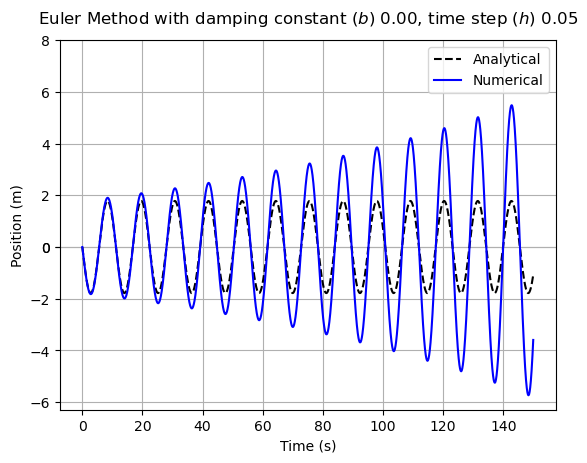

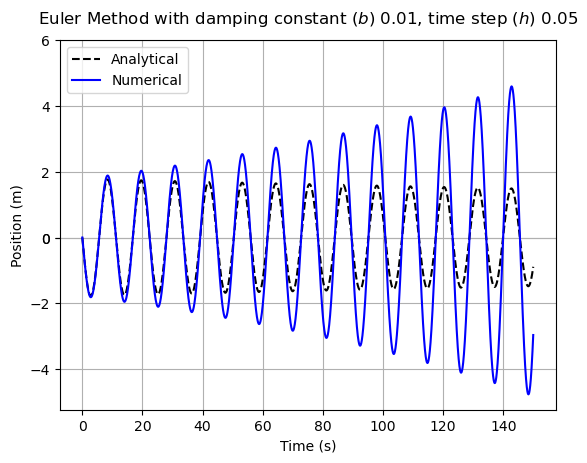

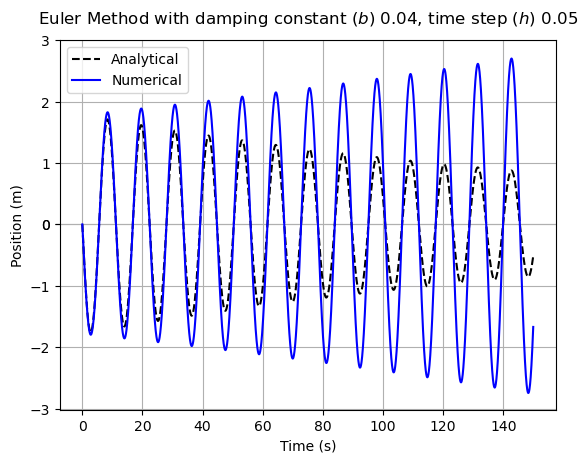

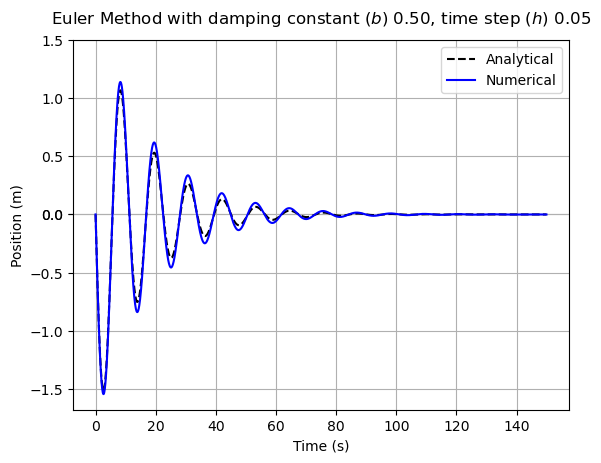

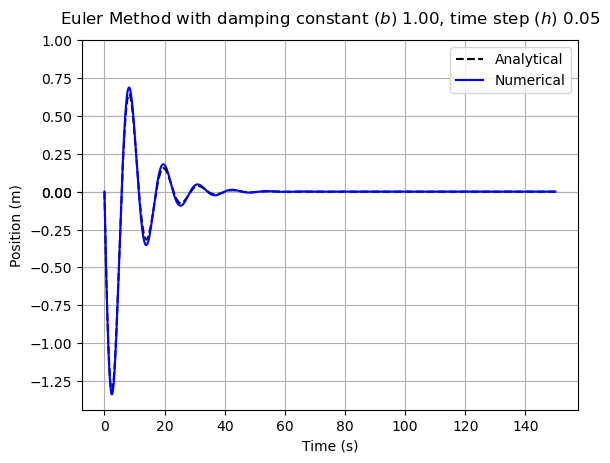

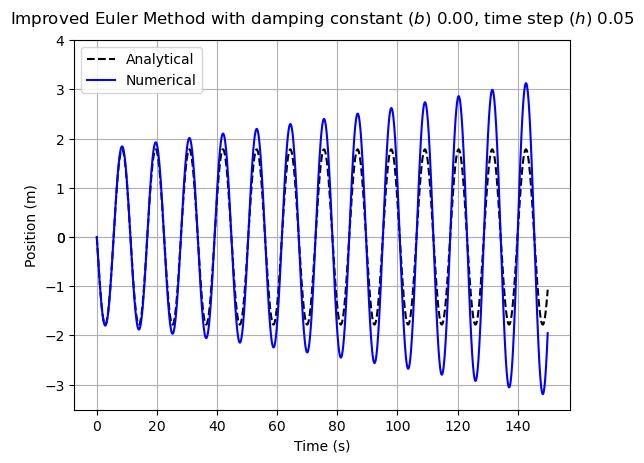

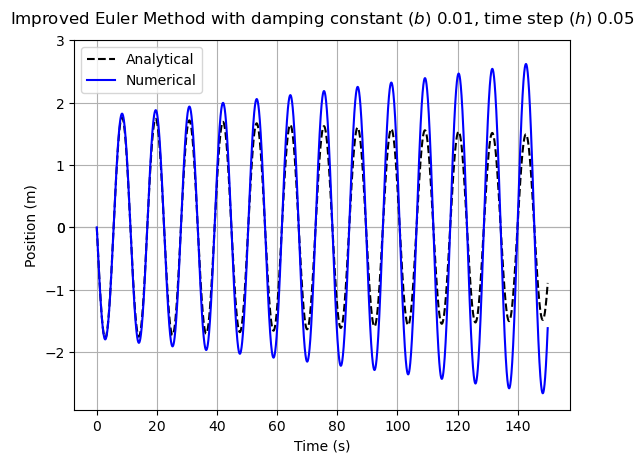

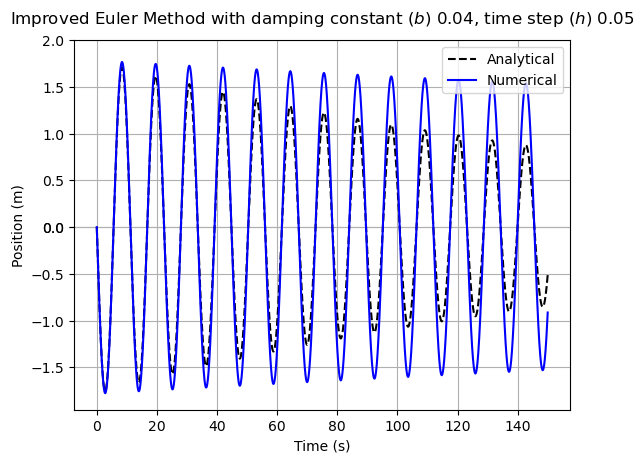

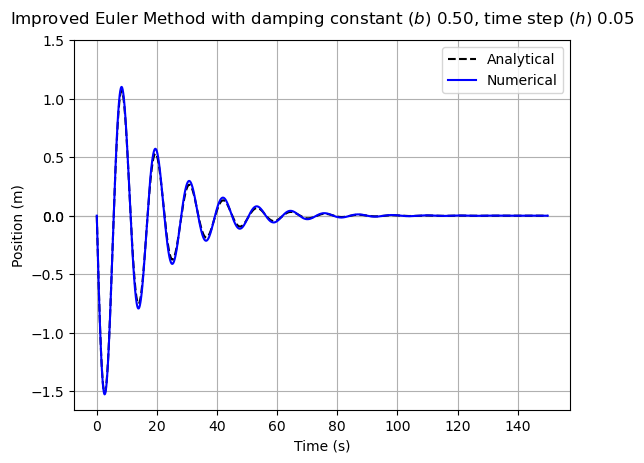

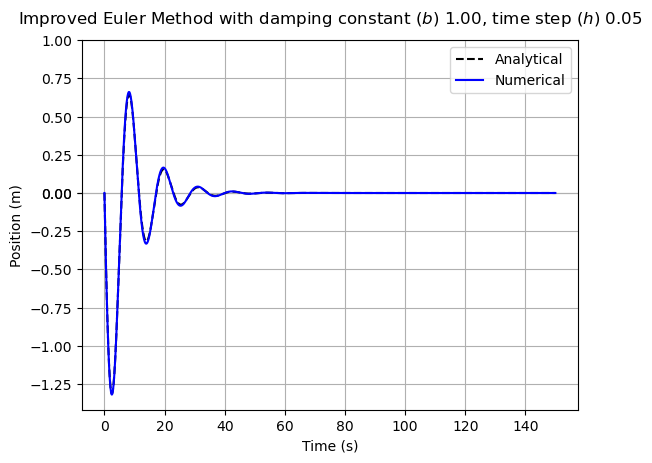

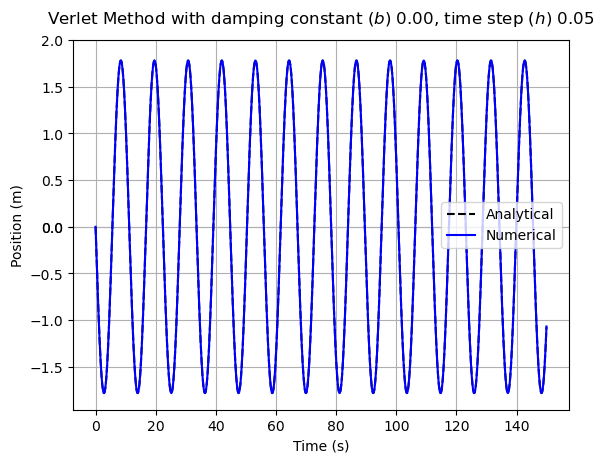

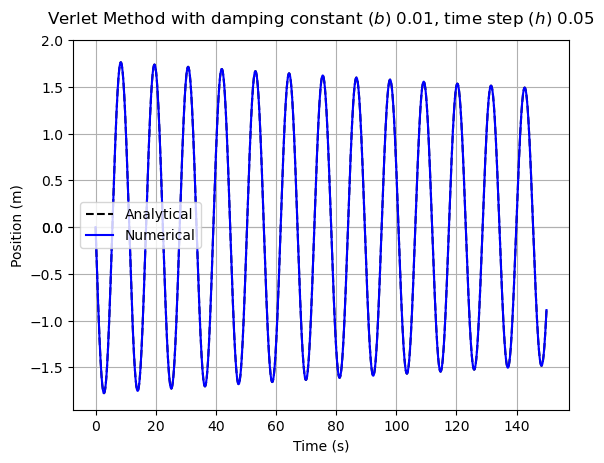

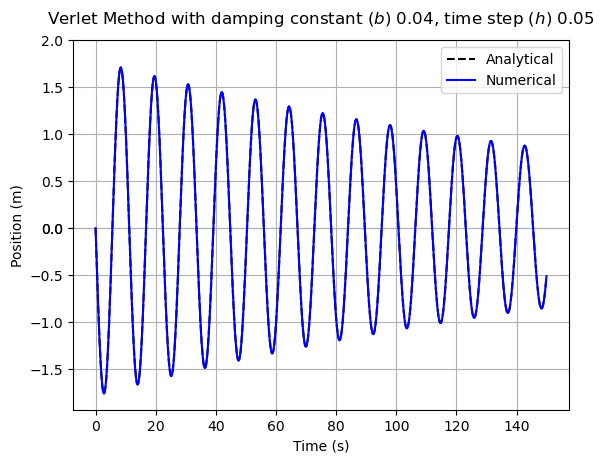

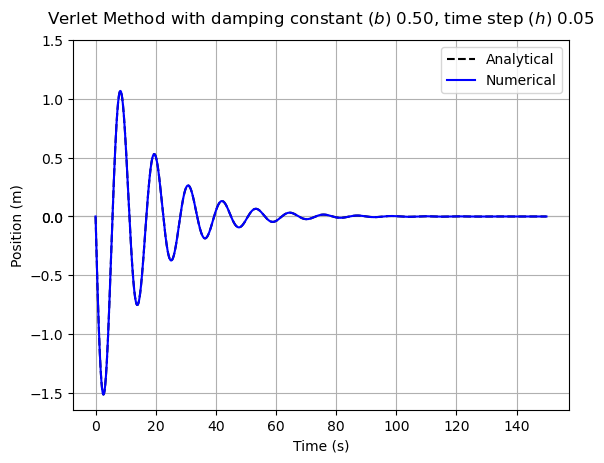

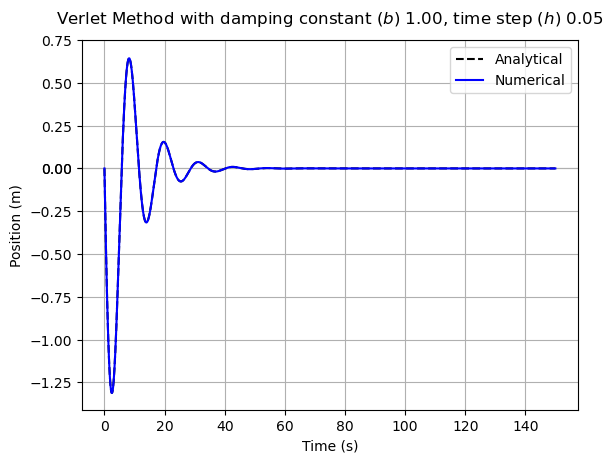

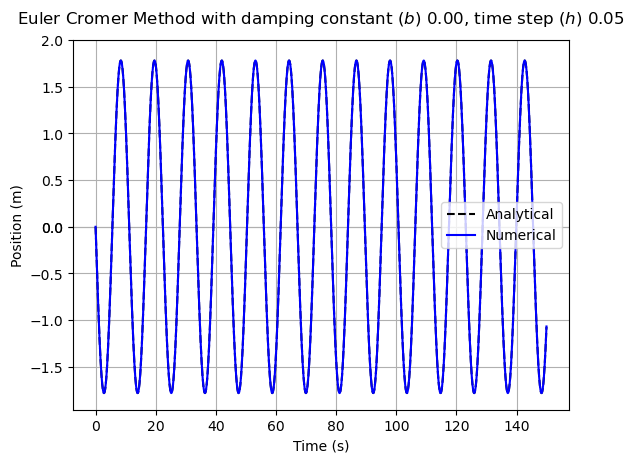

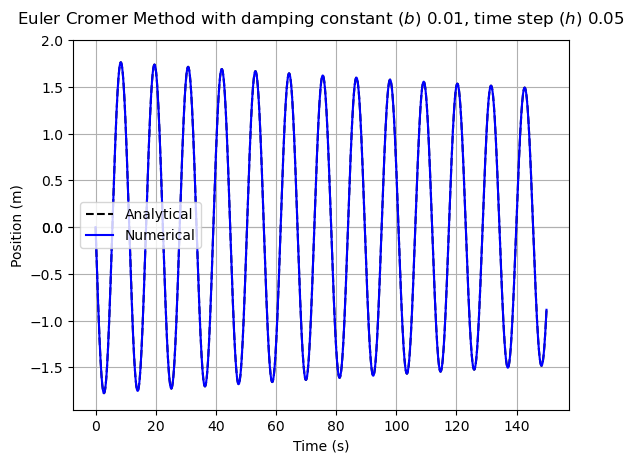

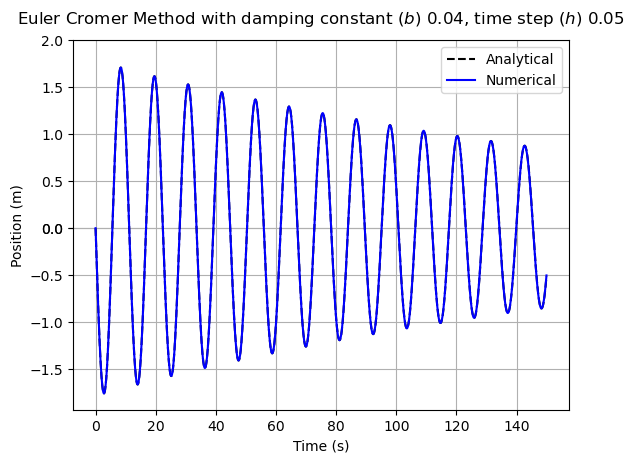

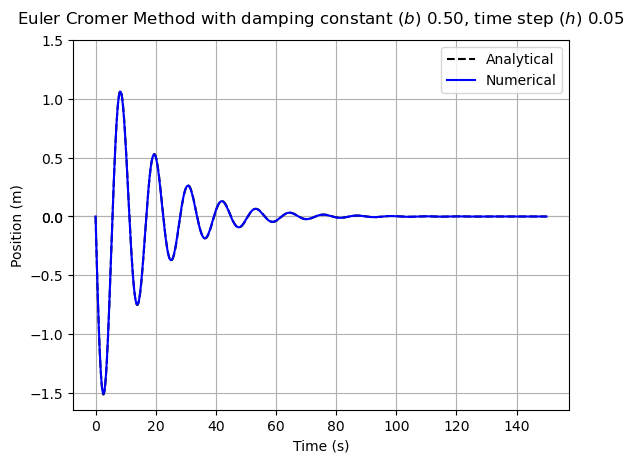

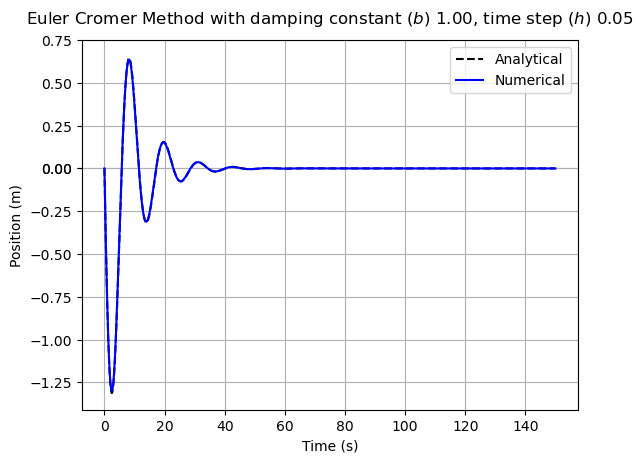

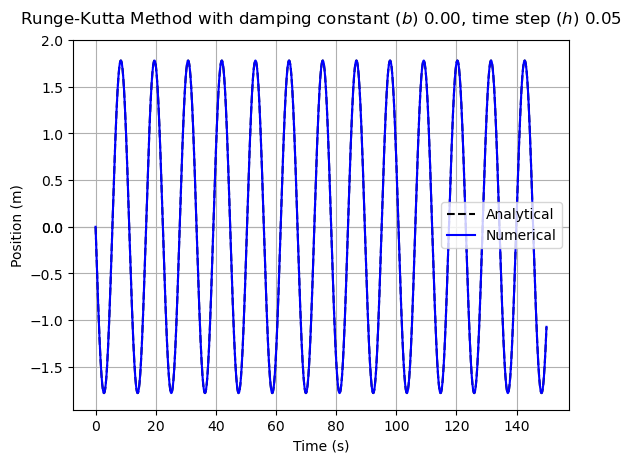

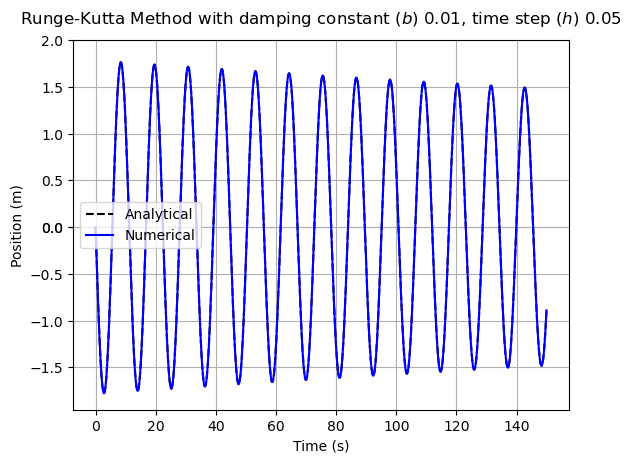

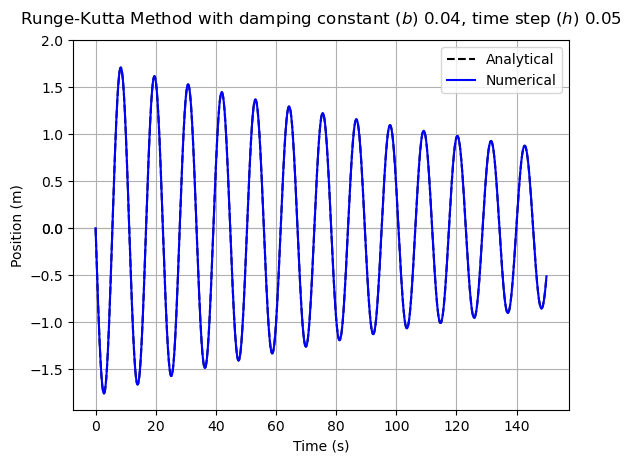

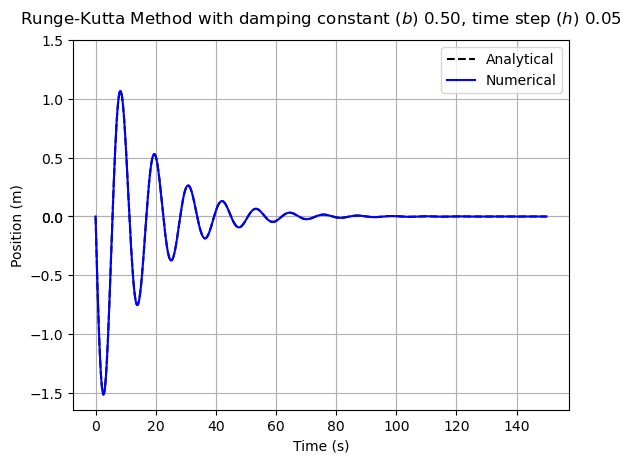

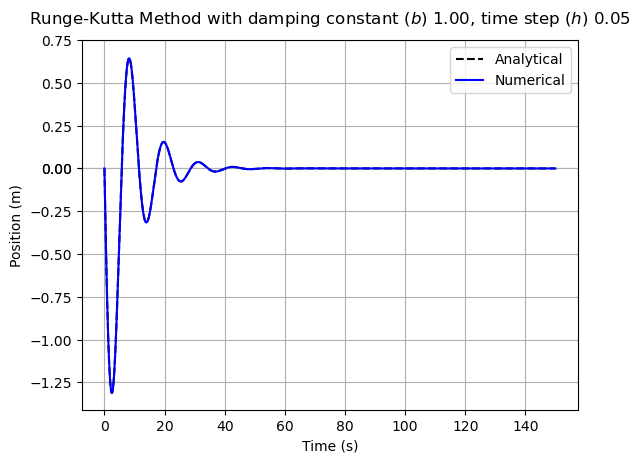

In [10]:
def vary_b(hstep):
    # Ensure number of steps is an integer
    nsteps = int(T / hstep)    
    for b in b_values:
        plotting(EulerMethod, b, nsteps, 'Euler Method', hstep)

    for b in b_values:
        plotting(ImprovedEulerMethod, b, nsteps, 'Improved Euler Method', hstep)

    for b in b_values:
        plotting(VerletMethod, b, nsteps, 'Verlet Method', hstep)
    
    for b in b_values:
        plotting(EulerCromerMethod, b, nsteps, 'Euler Cromer Method', hstep)
    
    for b in b_values: 
        plotting(RungeKuttaMethod, b, nsteps, 'Runge-Kutta Method', hstep)
vary_b(h_values[3])

It can be seen from these graphs that the Verlet, Euler-Cromer and Runge-Kutta methods are the most accurate because numerical line most closely fits the analytical solution. For the Euler and Improved Euler methods, they are least accurate for low damping constant values but improve in accuracy as $b$ increases to 1, whilst the damping constant does not have a significant effect on the accuracy of the Verlet, Euler-Cromer and Runge-Kutta methods.

## Investigating the effect of the time step value, $h$

Keeping the damping constant fixed at $b=1$, since this was the most accurate damping constant value for the five methods, the effect of the time step $h$ can be analysed by varying it between 0.1 and 0.0005 through the hstep_values list set up in the Initialisation section previously. 

Based on the appearance of local truncation error terms in the numerical methods, it should be expected that the smaller the time step, the higher the accuracy, particularly for when $h<1$.

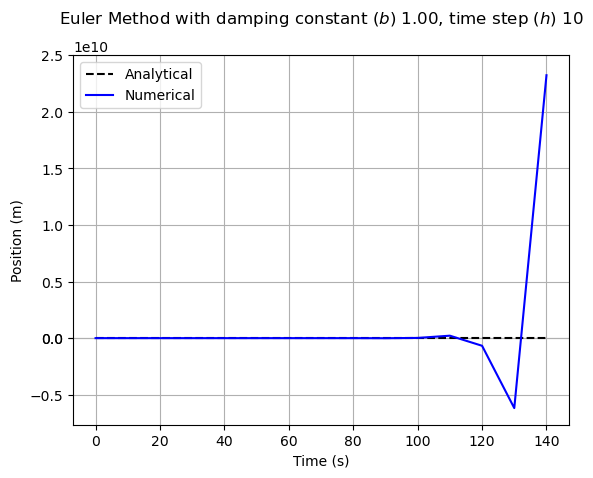

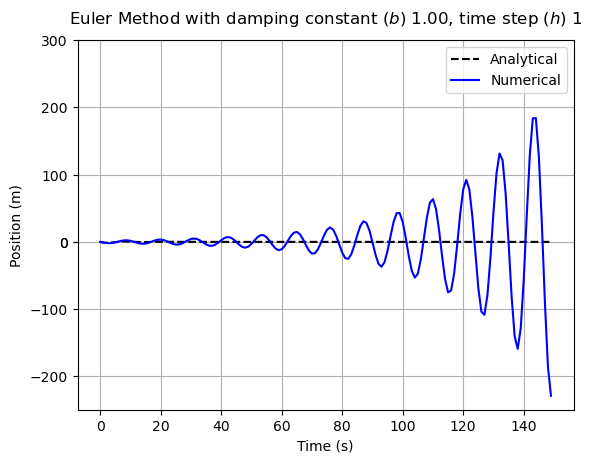

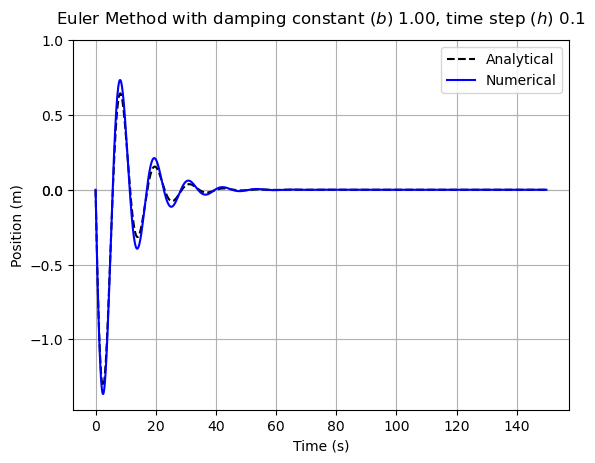

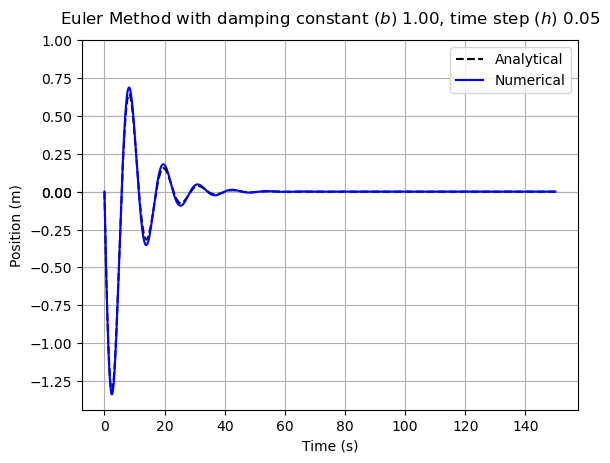

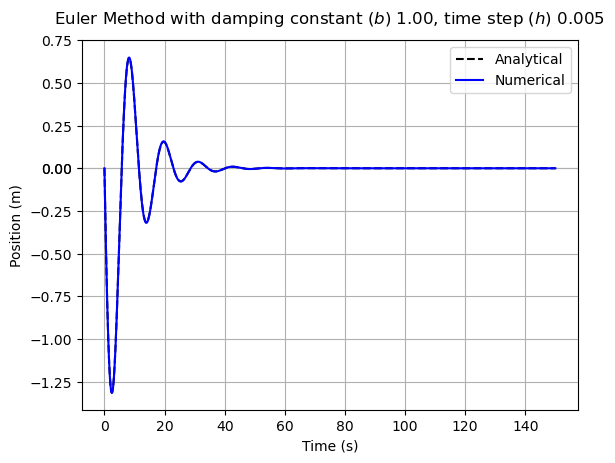

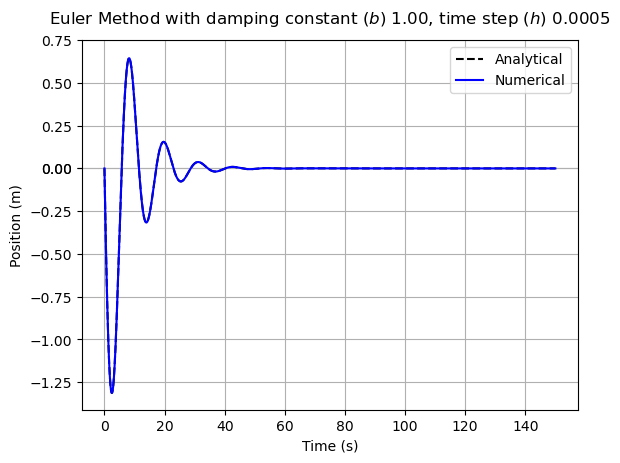

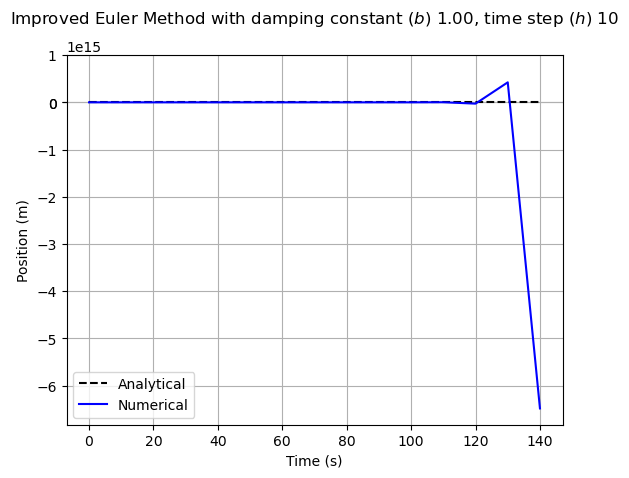

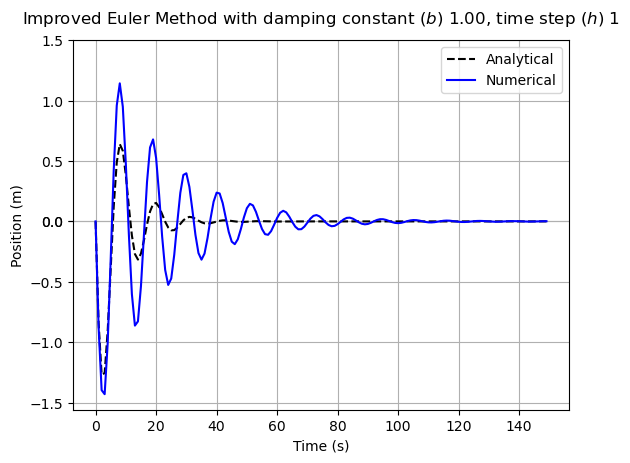

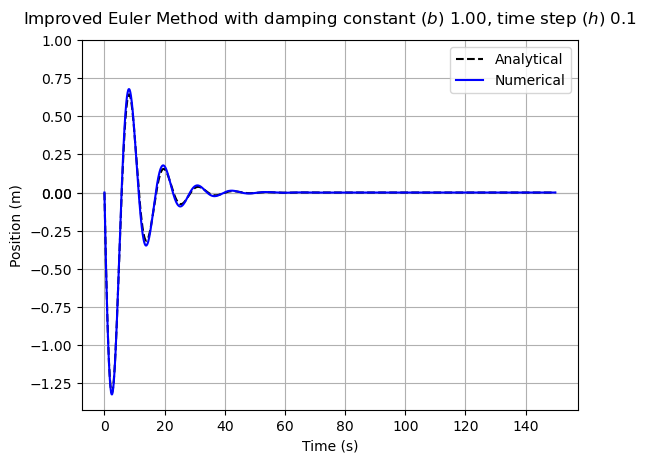

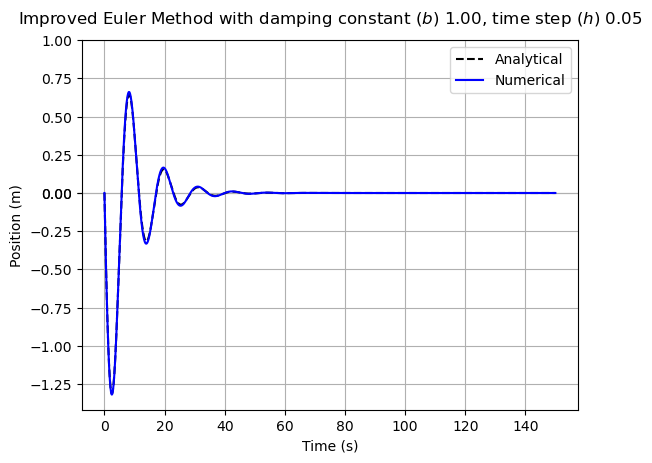

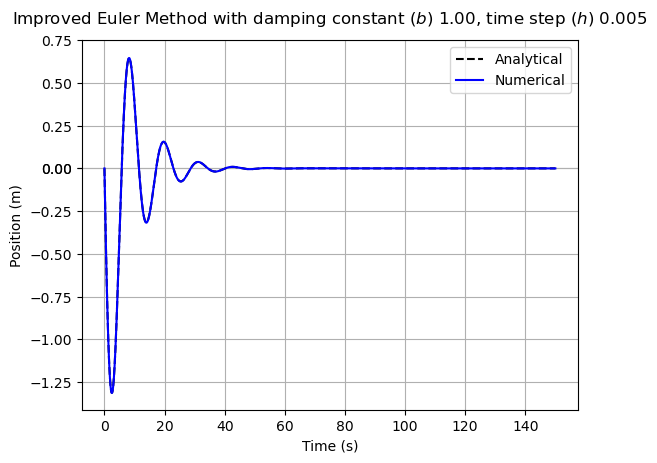

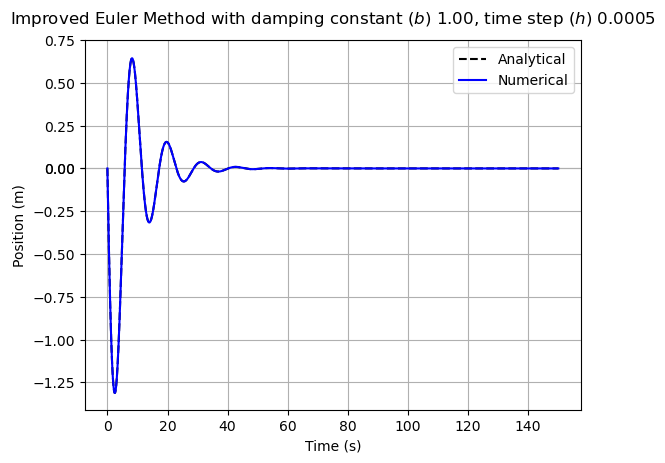

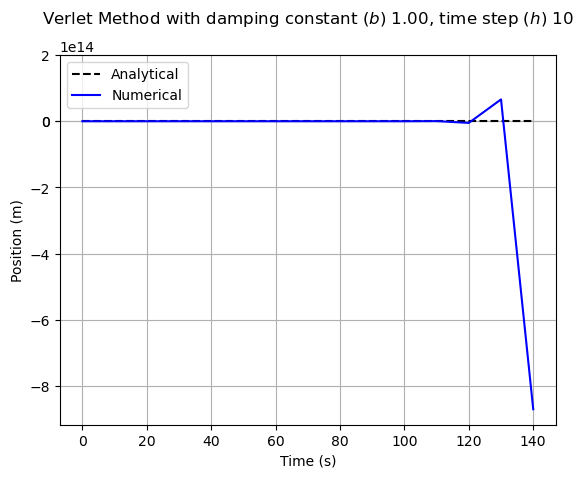

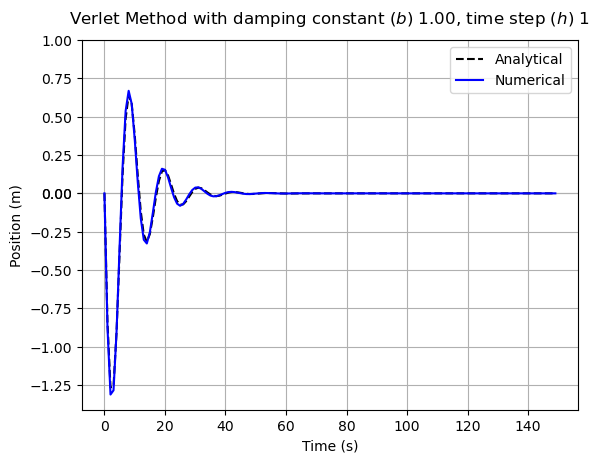

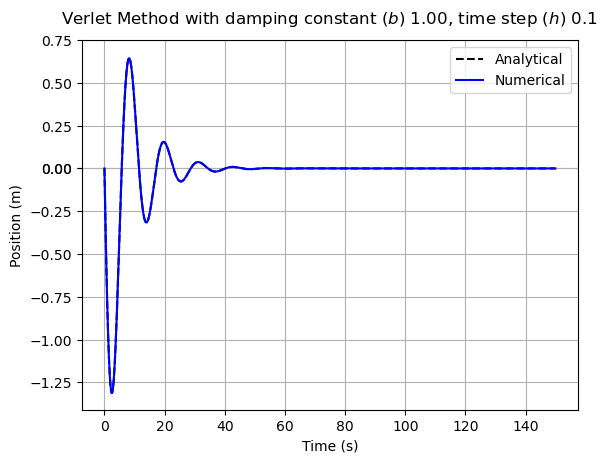

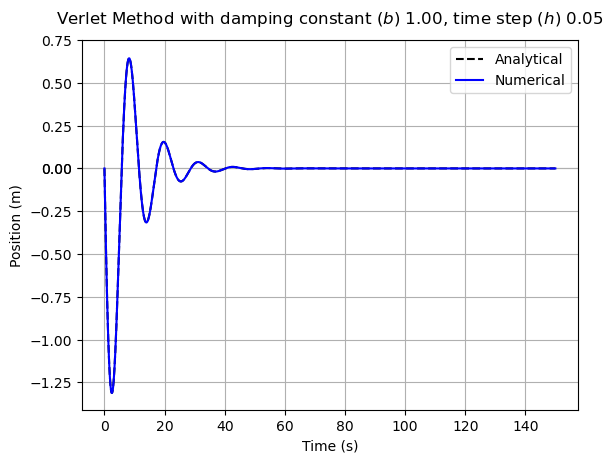

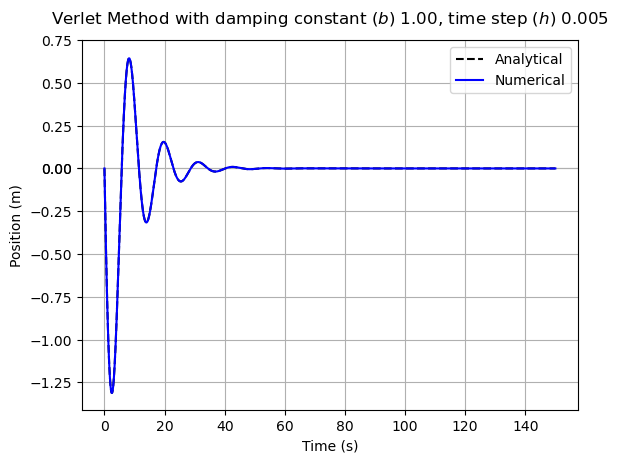

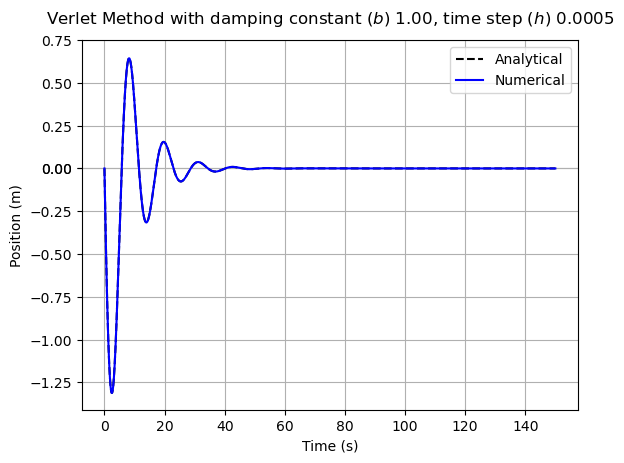

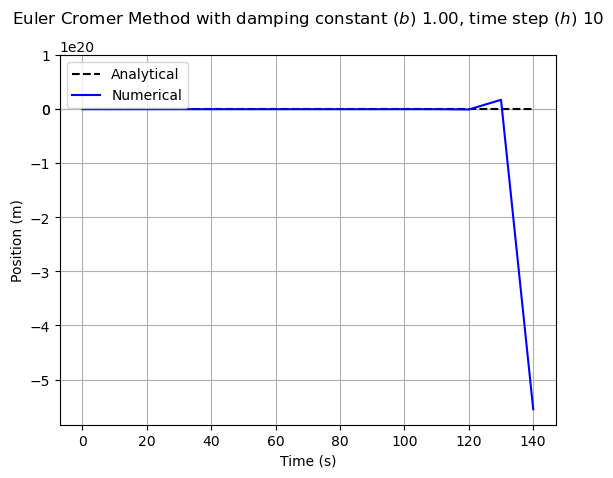

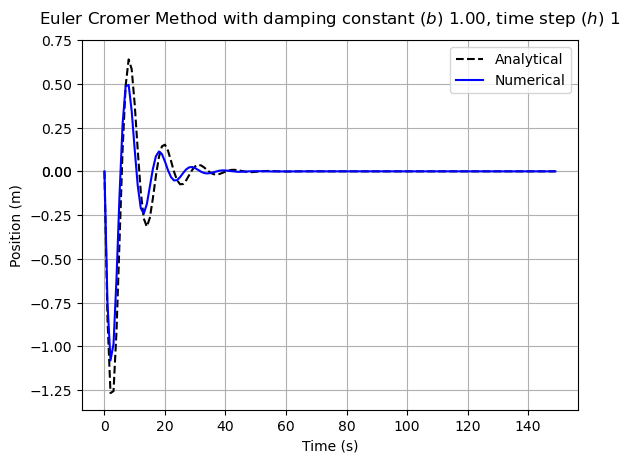

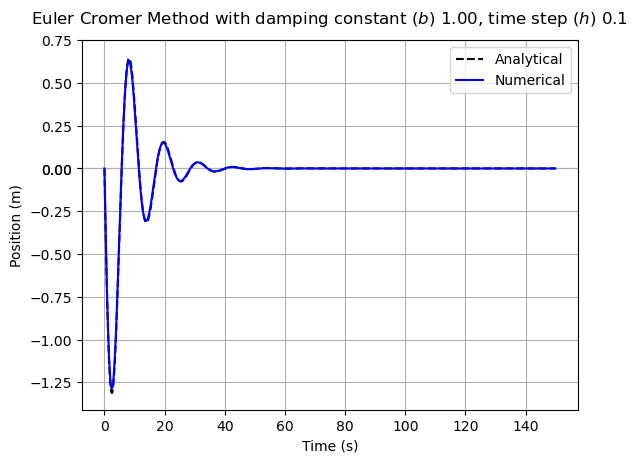

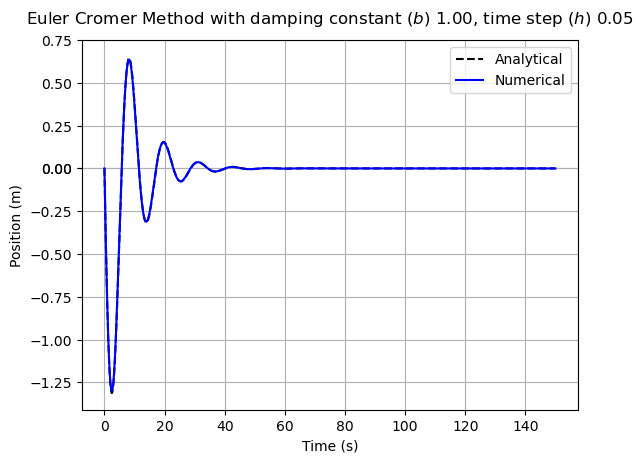

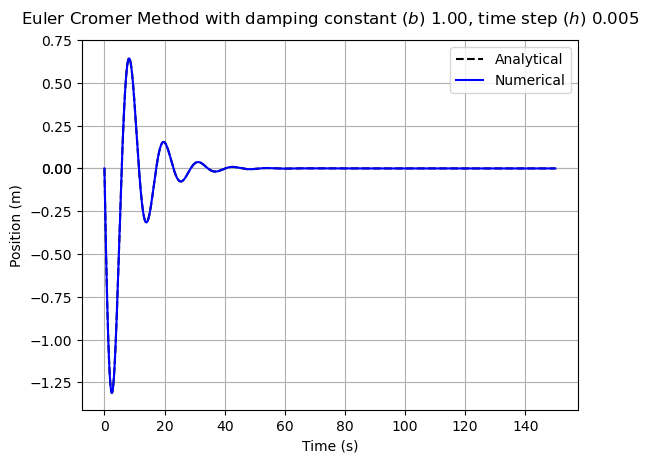

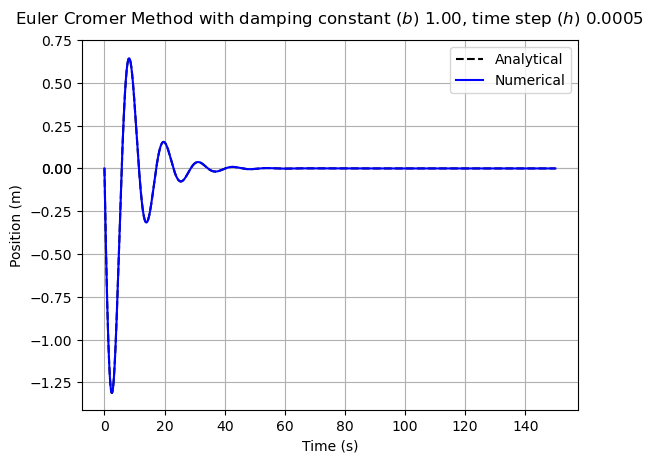

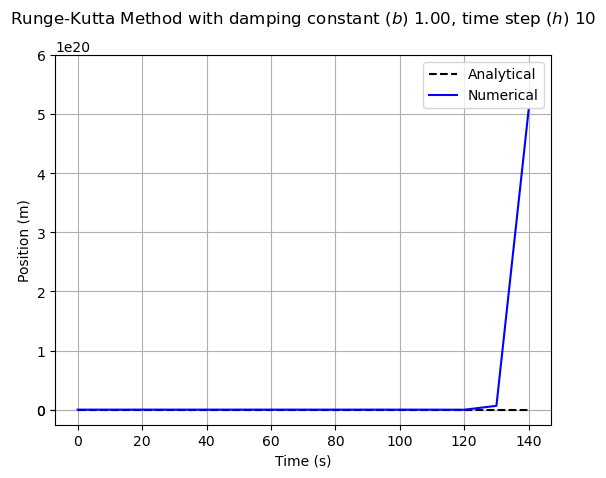

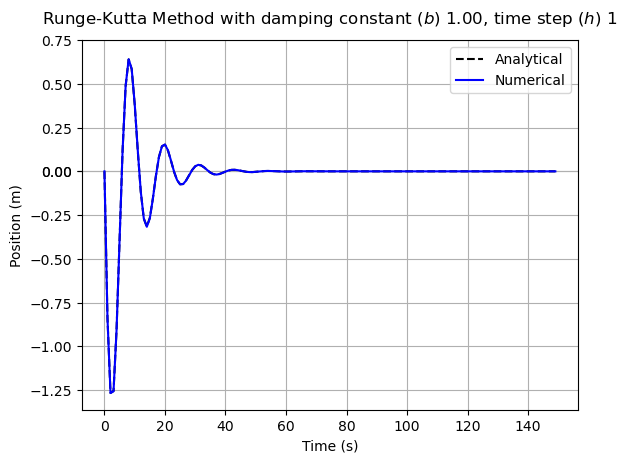

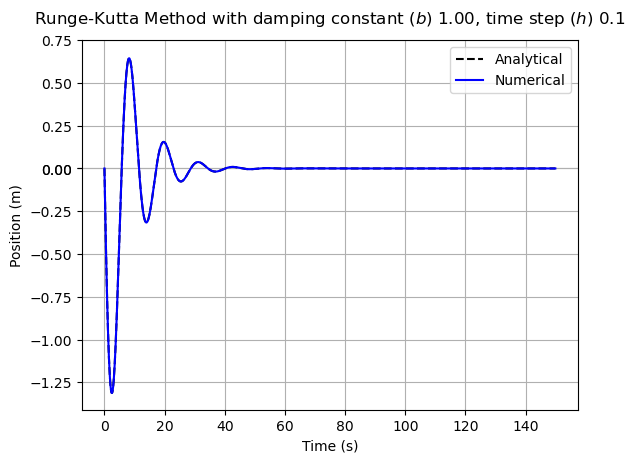

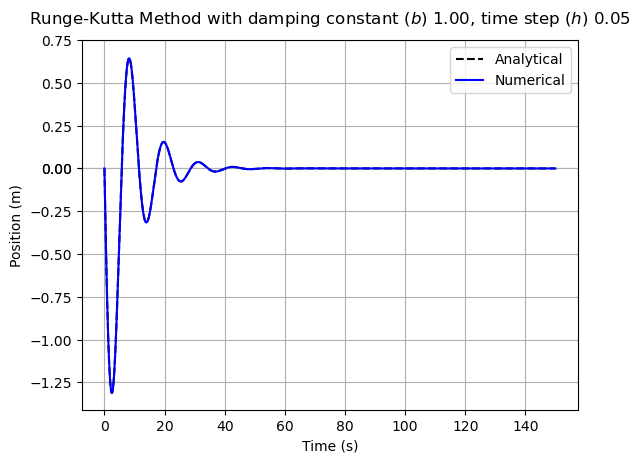

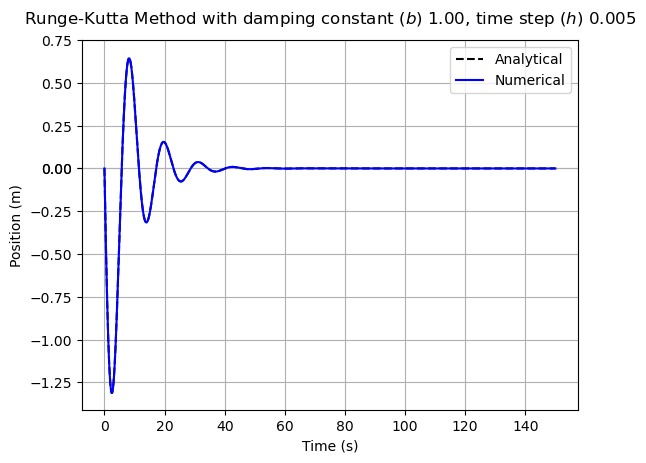

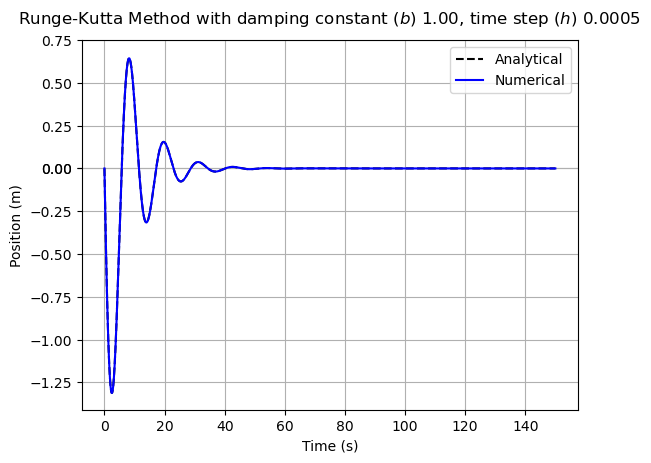

In [11]:
# Define function for varying the time step for each numerical method
def vary_hstep(b):
    for hstep in h_values:
        nsteps = int(T / hstep)    
        plotting(EulerMethod, b, nsteps, 'Euler Method', hstep)

    for hstep in h_values:
        nsteps = int(T / hstep)   
        plotting(ImprovedEulerMethod, b, nsteps, 'Improved Euler Method', hstep)

    for hstep in h_values:
        nsteps = int(T / hstep) 
        plotting(VerletMethod, b, nsteps, 'Verlet Method', hstep)
    
    for hstep in h_values:
        nsteps = int(T / hstep) 
        plotting(EulerCromerMethod, b, nsteps, 'Euler Cromer Method', hstep)
    
    for hstep in h_values:
        nsteps = int(T / hstep) 
        plotting(RungeKuttaMethod, b, nsteps, 'Runge-Kutta Method', hstep)
    
vary_hstep(b_values[4])

The graphs demonstrate the predicted trend, whereby for each method the numerical line overlaps more closely with the analytical line the smaller $h$ is. This improvement progresses quickly as $h$ drops, because the improvement in accuracy is undetectable from $0.05$. This means the time step used could be $0.05$ to save time in computation.

## Finding the most accurate method quantitatively

The best numerical method is that which most closely aligns with the analytical method. This can be visualised most clearly by plotting the absolute difference in $x$ values at some specified time $T$, 

$\lvert x_{num}(T) - x(T) \rvert$, 

as a function of $h$, the timestep. This will give a definitive error and therefore indication of accuracy for the numerical methods, rather than simply looking at the previous graphs and deciding how closely the numerical and analytical lines align.

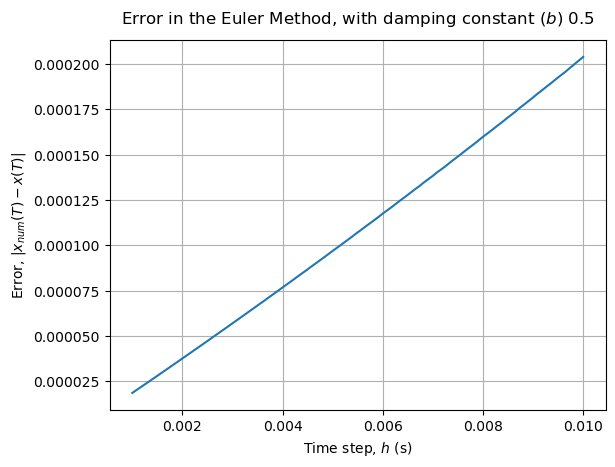

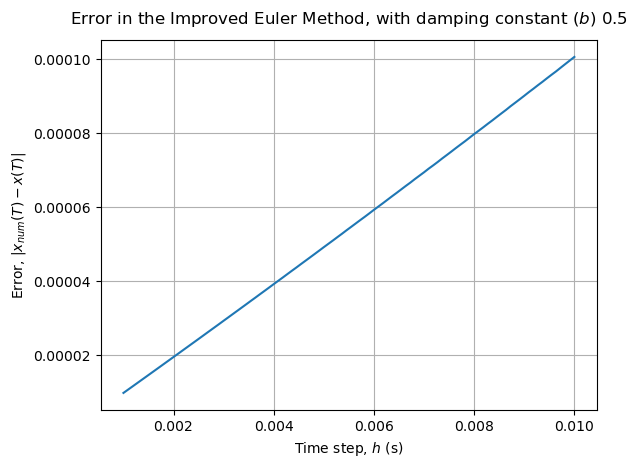

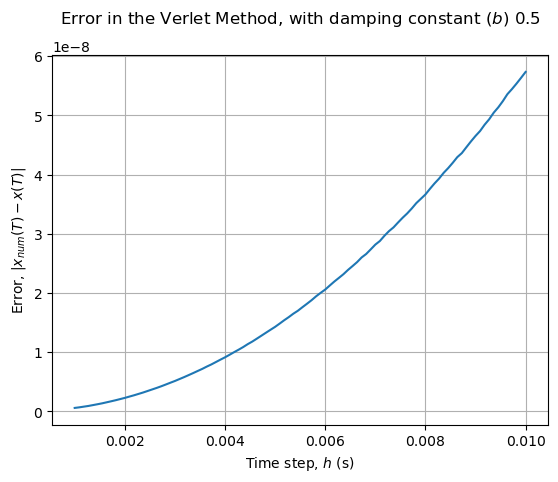

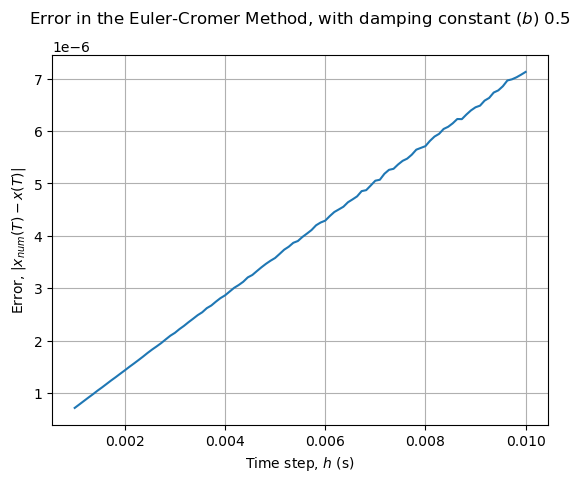

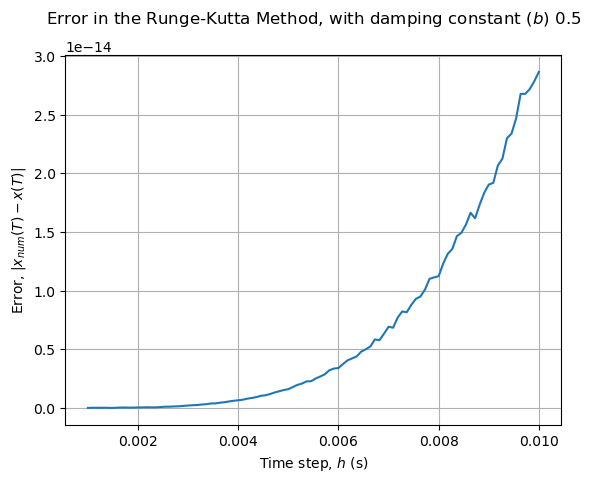

In [12]:
# Define function for plotting the errors of the numerical methods comapred to the time step
def plot_absolute_difference(numerical_method, name):
    b_value = 0.5
    hstep_list = np.linspace(0.001,0.01,100)#[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    nstep_list = (120 / np.array(hstep_list)).astype(int)
    
    # create empty list of zeros for the values of the differences between the numerical and analytical x values
    abs_x_diff = np.zeros(100)
    for i in range(0,100):
        # finding numerical method x value at time T = 120s
        x_values_num = numerical_method(x0, v0, nstep_list[i], hstep_list[i], b_value)[0]
        specific_x_num = x_values_num[nstep_list[i]-1]
            
        # finding analytical method x value at time T = 120s
        x_values_analytical = Analytic(x0, v0, b_value, np.arange(0,121,hstep_list[i])).real
        specific_x_analytic = x_values_analytical[nstep_list[i]-1]
            
        # calculating absolute value between the two x values
        abs_x_diff[i] = np.abs(specific_x_num - specific_x_analytic)
    fig = plt.figure()  
    ax = fig.add_subplot(111)
    ax.plot(hstep_list, abs_x_diff, label=numerical_method)
    
    ax.set_xlabel(r"Time step, $h$ (s)")
    ax.set_ylabel(r"Error, $|x_{num}(T) - x(T)|$")
    ax.set_title(r'Error in the '+name+', with damping constant ($b$) {0}'.format(b_value), loc='center', pad=12)
    ax.grid(True)
    plt.show()
    plt.close()

num_methods_list = [EulerMethod, ImprovedEulerMethod, VerletMethod, EulerCromerMethod, RungeKuttaMethod]
num_methods_names = ['Euler Method', 'Improved Euler Method', 'Verlet Method', 'Euler-Cromer Method', 'Runge-Kutta Method']
for i in range(0,5):
    plot_absolute_difference(num_methods_list[i], num_methods_names[i])   

From these graphs we see that for all numerical methods the error between the numerical and analytic method increases as $h$ increases. However, it remains the smallest on the Runge-Kutta method, thereby demonstrating that Runge-Kutta is the most accurate numerical method with a $b$ value of 0.5. Other $b$ values were tested that yielded the same results: Runge-Kutta is consistantly the most accurate, followed by the Verlet method. 

These graphs also show the relationship between the time step and the error, being linear for the Euler methods, quadratic for the Verlet method and quartic for the fourth-order Runge-Kutta method. This reflects the different orders of magnitude of the local truncation errors discussed in the derivation of the numerical methods above. 

## Plotting energy to investigate the effect of time step on accuracy

It is important that the numerical methods are able to conserve energy, because energy is conserved in the analytic solution and in the physical case of a mass-spring system. As such, the value of time step will be varied to investigate its effect on the accuracy of different methods with respect to how well they conserve energy over time. This is another way of assessing the effect of time step on accuracy. The energy equation used is:

$E = \frac{kx^2}{2} + \frac{mv^2}{2}$.

In [13]:
# Define function for calculating the energy of a numerical method
def find_energy(numerical_function, b_value, nsteps, hstep):
    x = numerical_function(x0, v0, nsteps, hstep, b_value)[0]
    v = numerical_function(x0, v0, nsteps, hstep, b_value)[1]
    #print('x', x)
    #print('v', v)
    energy = ((1/2) * k * x**2) + ((1/2) * m * v**2) 
    #print('energy', energy)
    return energy

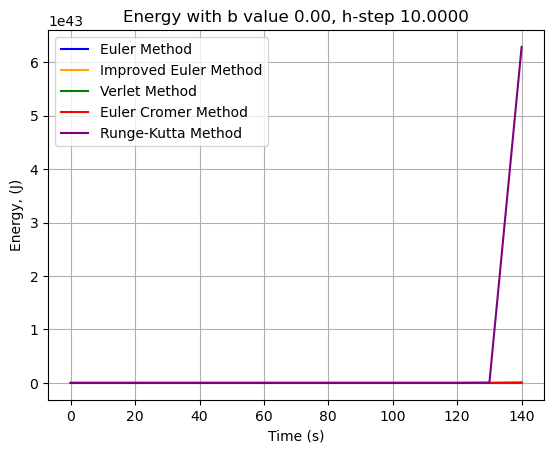

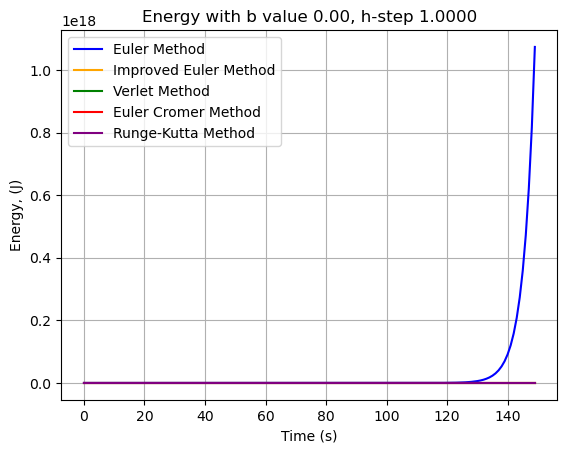

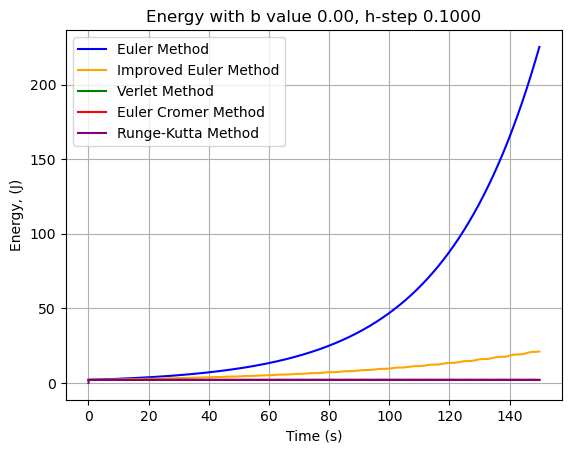

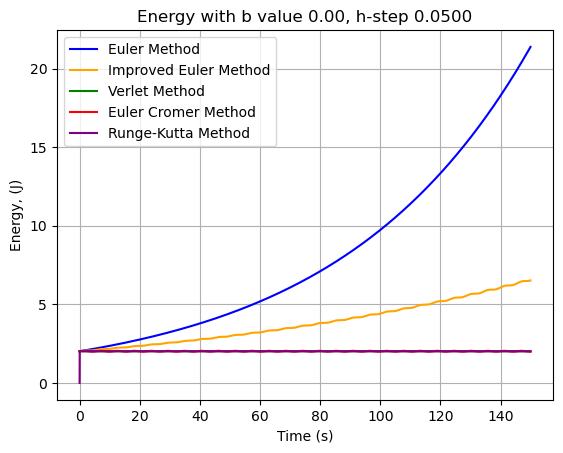

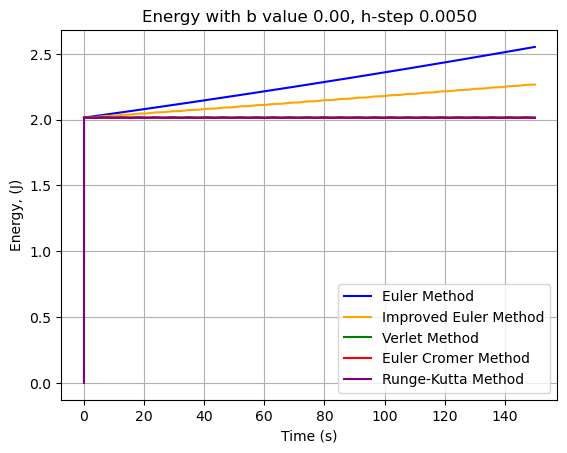

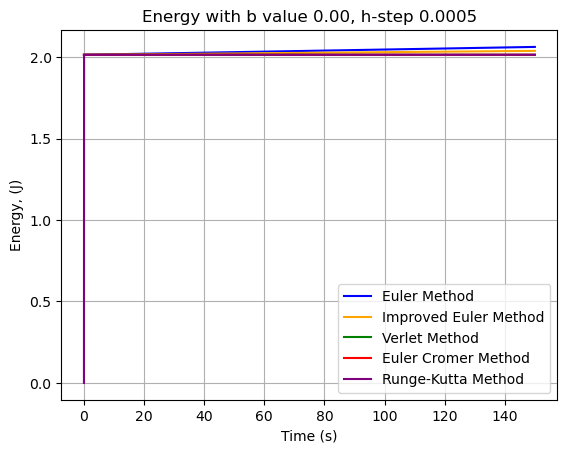

In [14]:
# Define function to plot the energy against time for all numerical methods on one graph
def plotting_energy(b_value, nsteps, hstep):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #(x, v) = Analytic(x0, v0, b_value, np.arange(0,T,hstep))
    #energy_analytic = ((1/2) * k * x**2) + ((1/2) * m * v**2)
    
    # Plot energy against time
    #ax.plot(np.arange(0,T,hstep), energy_analytic, '-', color='black', label='Euler Method')
    ax.plot(np.arange(0,T,hstep), find_energy(EulerMethod, b_value, nsteps, hstep), 'b-', label='Euler Method')
    ax.plot(np.arange(0,T,hstep), find_energy(ImprovedEulerMethod, b_value, nsteps, hstep), '-', color='orange', label='Improved Euler Method')
    ax.plot(np.arange(0,T,hstep), find_energy(VerletMethod, b_value, nsteps, hstep), 'g-', label='Verlet Method')
    ax.plot(np.arange(0,T,hstep), find_energy(EulerCromerMethod, b_value, nsteps, hstep), 'r-', label='Euler Cromer Method')
    ax.plot(np.arange(0,T,hstep), find_energy(RungeKuttaMethod, b_value, nsteps, hstep), '-', color='purple', label='Runge-Kutta Method')

    # Label graph
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Energy, (J)")
    ax.set_title('Energy with b value {0:.2f}, h-step {1:.4f}'.format(b_value, hstep))
    ax.legend()
    ax.grid(True)
    plt.show()
    plt.close()

for hstep in h_values:
    nsteps = int(T / hstep)    
    plotting_energy(0, nsteps, hstep)

These graphs show that the greater the time step, the greater the errors of non-symplectic methods such as Euler and Improved Euler accumulate over time to show deviation from conserved energy. The Runge-Kutta method is also non-symplectic as shown by the deviations in conserved energy at very high time step ($h=10$) and also for lower time step values where there is deviation at the start of the time. 

The Verlet and Euler-Cromer methods are not very visible on the graphs because they lie under the Runge-Kutta line and oscillate very closely around a constant energy value, indicating their energy conservation and symplectic nature.

Therefore, although the Runge-Kutta method is the most accurate according to the magnitude of the truncation errors that occur, it is not the most suitable method to use for the investigations in the next part of the report, as it is non-symplectic. Instead, the Verlet method shall be used due to its energy-conservation property and its very high accuracy, and a time step of $h=0.05$ shall be used for accuracy, but also to save time in computation.

## Verlet Method - comparing different damping constants around the critical value

The critical value for the damping constant, $b_{cr}$, is defined as the damping value where the oscillations decay to zero in the shortest possible time, and is calculated according to the equation:

$b_{cr}^2 = 4km$.

For the initial conditions stated in the Initialising Code section, $b_{cr} = 4.52$ (2.d.p).

Using the Verlet Method (as we have established it as the most accurate method), and a time step value of $h=0.05$, the numerical solution to the equation of motion will be plotted using:\
a) $b = \frac{1}{2}b_{cr}$ \
b) $b = b_{cr}$ \
c) $b = 2b_{cr}$.

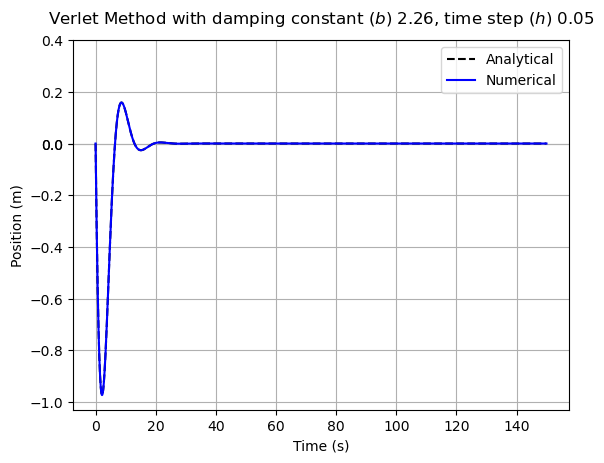

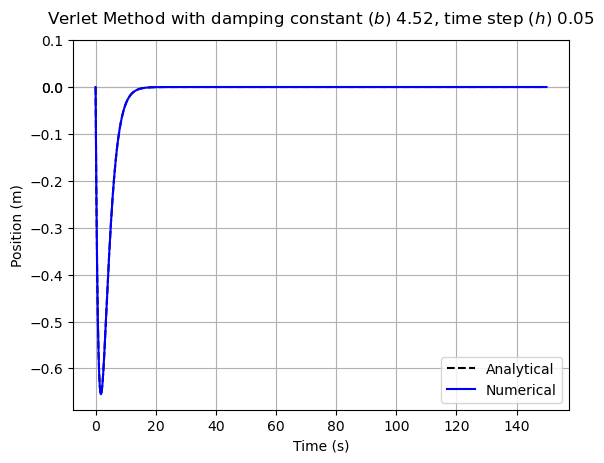

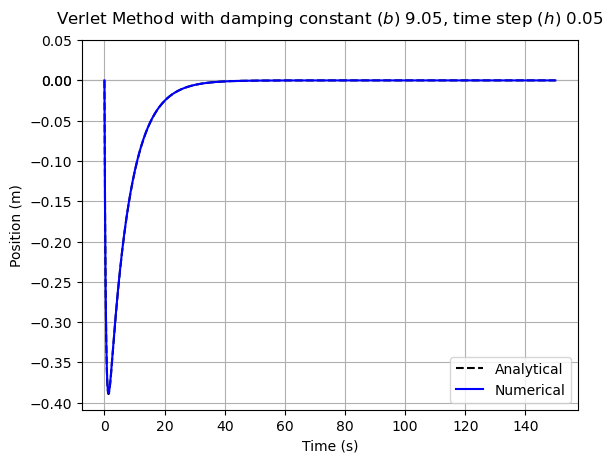

In [15]:
# Calculate critical damping value
b_cr = np.sqrt(4*k*m)

# Define function to iterate through damping constant values above and below the critical damping
def b_compared_to_b_critical(hstep):
    # Ensure number of steps is an integer
    nsteps = int(T / hstep)  
    for b in [(b_cr/2), b_cr, (2*b_cr)]:
        plotting(VerletMethod, b, nsteps, 'Verlet Method', hstep)

b_compared_to_b_critical(h_values[3])

We see that in the first graph, for $b = \frac{1}{2}b_{cr}$, there is still a small amount of oscillation such that the position doesn't return to equilbrium as quickly as possible, taking over 20 seconds.

Similarly in the third graph, where $b = 2b_{cr}$, though there is no oscillation, the return to equilbrium is slow at approximately 40 seconds. It is a shallower curve than in the second graph, $b = b_{cr}$, because it simulates being over-damped, whereas the second graph at critical damping returns to equilibrium in the fastest time, under 20 seconds. 

# External driving forces

The Verlet method, being the most accurate numerical method, can also be used to analyse how the mass system will behave when external driving forces are applied to it, e.g., a sudden, constant "push" for a short time interval, or a prolonged sinusoidal external driving force. 

Below are the functions that describe the nature of the driving force, and a revised Verlet Method function that allows the inclusion of an external force. This was derived as before, but starting from the forced oscillation equation of motion such that the acceleration equation becomes:

$a_i = -\frac{k}{m}x_i -\frac{b}{m}v_i + \frac{F_i}{m}$ ,

where $F_i$ is the external force. This is subsituted into the Verlet position equation with the Verlet velocity equation, stated in the Verlet Method section, to simplify to:

$x_{i+1} = Ax_i + Bx_{i-1} + \frac{2h^2F_i}{D}$, 

where $A = \frac{2\left( 2m - kh^2 \right)}{D}$, $B = \frac{bh - 2m}{D}$, and $D = 2m + bh$ as before. This is very similar to the original Verlet position equation, but with an additional term to include the external force. 

The final function below plots the graphs to depict the system's behaviour. 

In [16]:
# Function to compute the driving force
def driving_force(t, force_type, push_interval1, push_interval2, amplitude, ang_frequency):
    # Check if time is within 'external force' time interval to see whether force should be applied
    if push_interval1 < t < push_interval2:
        if force_type == 'constant':
            # codes a narrow Gaussian function to have a continuous, realistic function
            sigma = 0.08
            mu = (push_interval1 + push_interval2) / 2
            return ( 1 / (sigma * np.sqrt(2*np.pi)) ) * np.exp( -(t - mu)**2 / (2 * sigma**2))
        else:   
            # force_type = 'sinusoidal'
            amplitude = 1
            return amplitude * np.sin(ang_frequency * t)
    else:
        return 0

# Updated Verlet function to include a non-zero external force
def VerletExternalForce(x0, v0, nsteps, hstep, b, force_type, push_interval1, push_interval2, amplitude, ang_frequency):
    # Find x0 and x1 using Euler method, hence input '2' for nsteps to only find first 2 values
    initial_xs = ImprovedEulerMethod(x0, v0, 2, hstep, b)[0] 
    initial_vs = ImprovedEulerMethod(x0, v0, 2, hstep, b)[1] 

    # Create empty arrays ready for the values of x and v
    x_array = np.zeros(nsteps)
    v_array = np.zeros(nsteps)
    
    # Assign initial conditions
    x_array[0] = initial_xs[0]
    x_array[1] = initial_xs[1]
    x_prev = initial_xs[0]
    x = initial_xs[1]
    
    v_array[0] = initial_vs[0]
    v_array[1] = initial_vs[1]
    
    # Setting A, B & D coefficients
    D = (2*m) + (b*hstep)
    A = 2 * ((2*m) - (k*(hstep**2))) / D
    B = ((b*hstep) - (2*m)) / D
    
    for i in range(2, nsteps):
        # Set external force depending on the time:
        t = (i-1) * hstep   # time (s) at the previous position
        F = driving_force(t, force_type, push_interval1, push_interval2, amplitude, ang_frequency)   # external force (N)
        
        # For each configuration at step i, calculate x (in m)
        x_temp = x
        x = A*x + B*x_prev + ((2 * hstep**2 * F) / D)   # calculates the next x = x_{i+1}, including F(t_i)
        x_array[i] = x       # updates the x_array for this next x value.
        x_prev = x_temp
        
        # Set external force to next value, 
        t = (i) * hstep   # time (s) at the current position to use to find the next position
        F = driving_force(t, force_type, push_interval1, push_interval2, amplitude, ang_frequency)   # external force (N)
        x_next = A*x + B*x_prev + ((2 * hstep**2 * F) / D) # calculates x_{i+2} to use in calculating v_{i+1},
                                                           # so the x_array and v_array will have the same length 
                                                           # and be updating the same index
        v = (x_next - x_prev) / (2*hstep)   # calculates v_{i+1}
        v_array[i] = v       # updates the v_array for this next v value, for same index as the x value
        
        
    return x_array, v_array

In [17]:
# Plot results
def plot_driving_force(positions, velocities, time, hstep, force_type, push_interval1, push_interval2, ang_frequency):    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(time, positions, label='Displacement')

    x_segment = np.linspace(push_interval1, push_interval2, 100)
    ax.fill_between(x_segment, y1=np.min(positions), y2=np.max(positions), color='#FF8F00', alpha=0.2)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Displacement (m)')
    if force_type == 'constant':
        ax.set_title('Verlet Method for mass system with '+force_type+' Driving Force')
    else:
        ax.set_title('Verlet Method for mass system with '+force_type+' Driving Force, frequency '+ang_frequency+' rad/s')
    ax.grid(True)
    ax.legend()
    plt.show()

## A sudden 'push' - constant driving force

To explore a sudden application of a force (a 'push') where the push is applied at different points in an oscillation, a narrow Gaussian function is applied as the external push. This is because it is a continuous function, unlike a sudden step function, thereby making it more realistic. The Gaussian function used is:

$F(t) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left( {\frac{-(t-\mu)^2}{2\sigma^2}} \right)$,

where $\sigma = 0.08$ and $\mu$ is determined by the midpoint of time interval provided, e.g. 22.5 for the case where the push occurs between 20 seconds and 25 seconds. The time intervals are all 5 seconds long, and the time when the push is applied is shaded in orange on the graphs. 

When applied at a variety of points along a period, the force applied will sometimes be in the same direction and sometimes in the opposite direction to the instantaneous velocity.

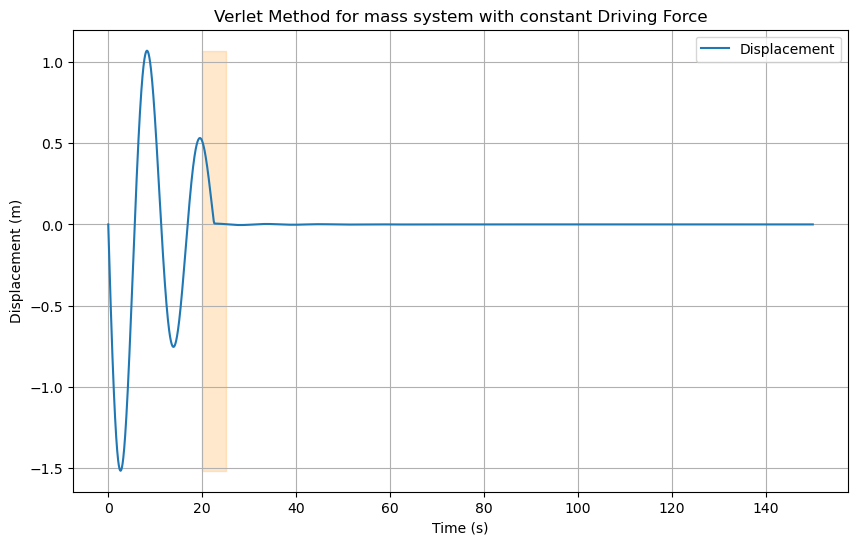

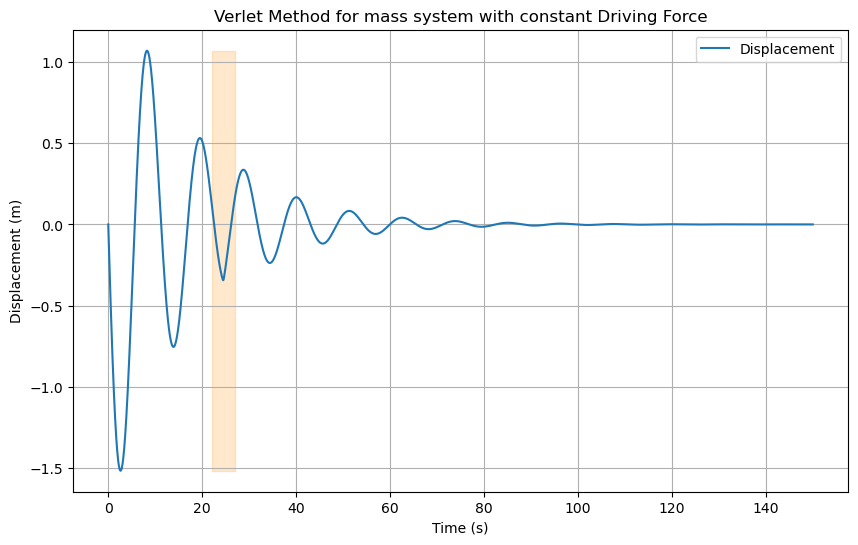

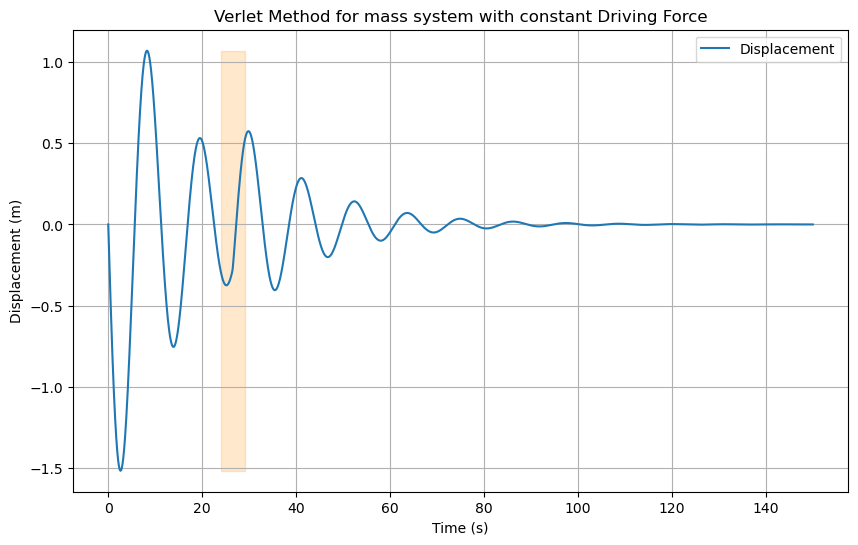

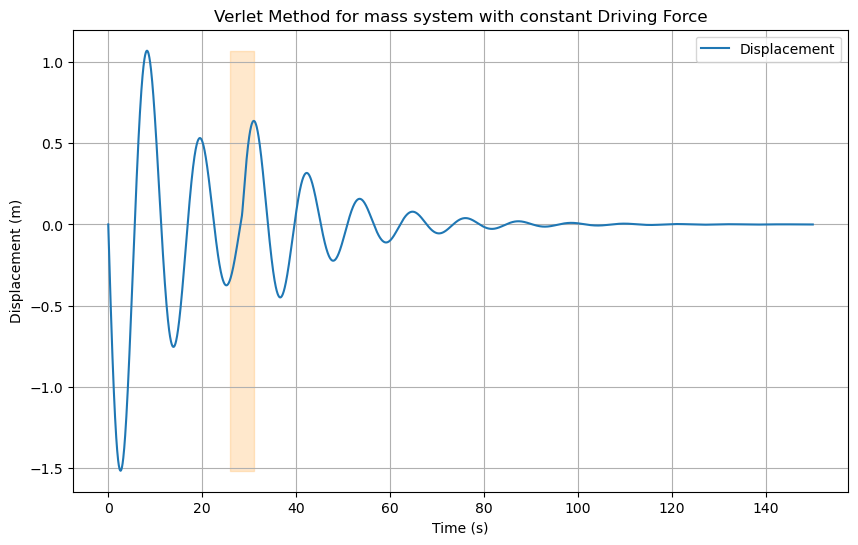

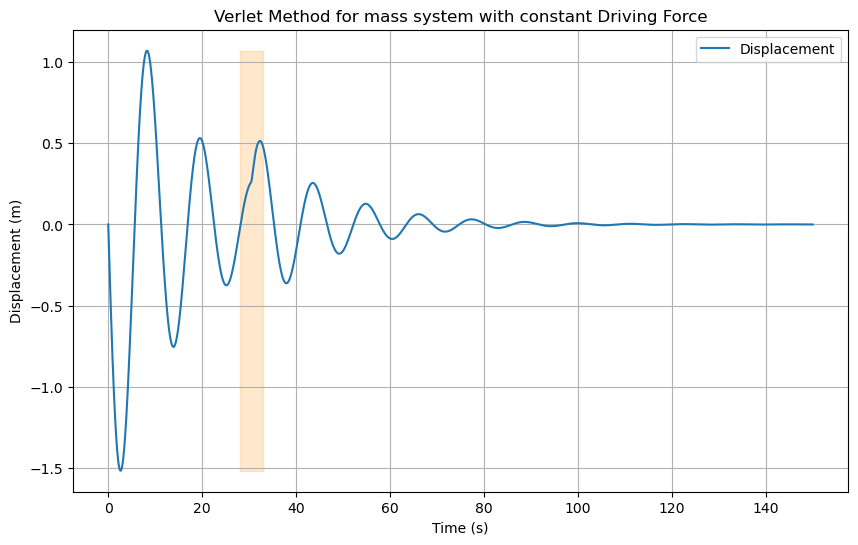

In [18]:
# Time parameters
h = h_values[3]  # 0.05 s
nsteps = int(T / h)  # Number of time steps
TIME = np.arange(0, T, h)  # Time array

# Damping constant value
b = b_values[3]   # 0.5 kg/s

# For constant driving force, 'push'
# Create list of time intervals to apply 'push' at and iterate through list
PUSH_TIMES_LIST = [(20, 25), (22, 27), (24, 29), (26, 31), (28, 33)]
for timeset in PUSH_TIMES_LIST:
    POSITIONS, VELOCITIES = VerletExternalForce(x0, v0, nsteps, h, b, 'constant', timeset[0], timeset[1], None, None)
    plot_driving_force(POSITIONS, VELOCITIES, TIME, h, 'constant', timeset[0], timeset[1], None)

The first graph demonstrates near-complete cancellation due to the force being applied in the opposite direction to the velocity, thus resulting in a flat line after.

Where the force was applied at a different point in the cycle such that it was in the same direction as the velocity, it boosted the displacement value, such as in the fourth graph with a time interval of 26-31 seconds. The mass then took longer to reach equilibrium as it had to be damped from a greater displacement. 

## Sinusoidal external driving force

Below shows the same setup but instead of a short "push", the system experiences a prolonged sinusoidal external driving force. The force lasts to the end of the total time the model runs for to ensure that any transient effects die down in the system, again shaded orange on the graph. 

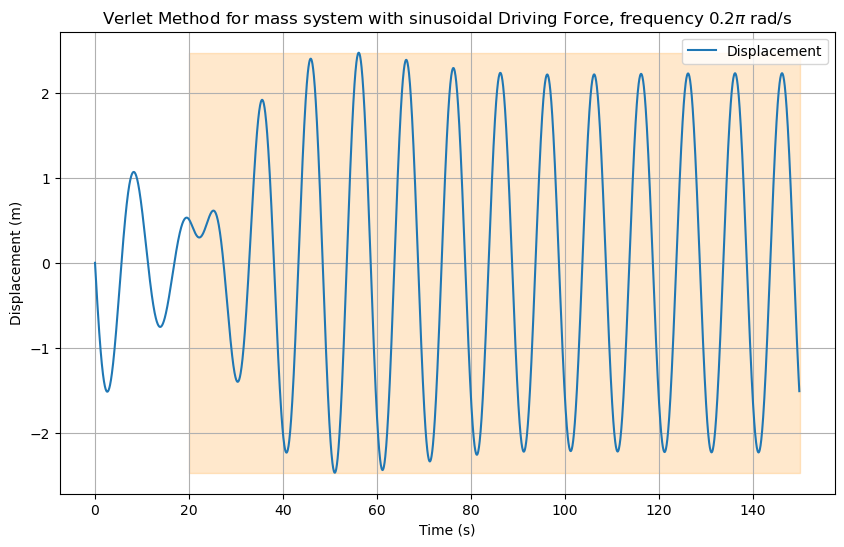

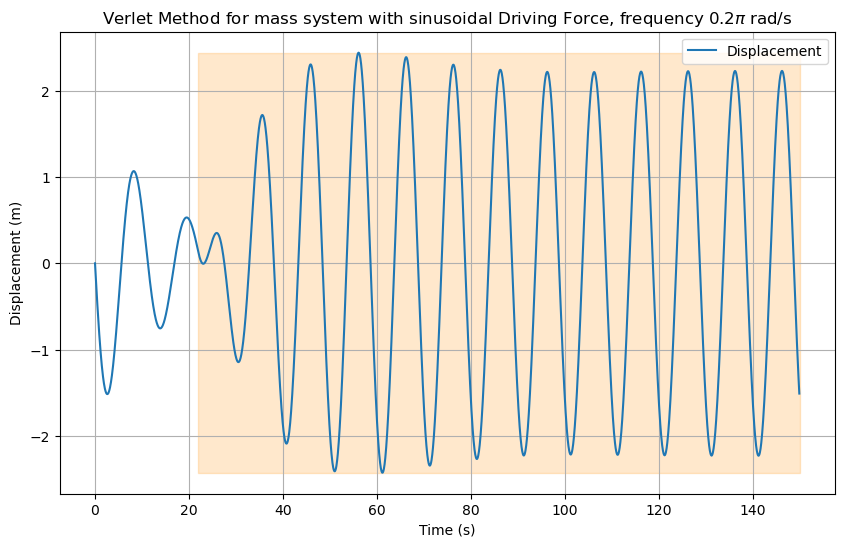

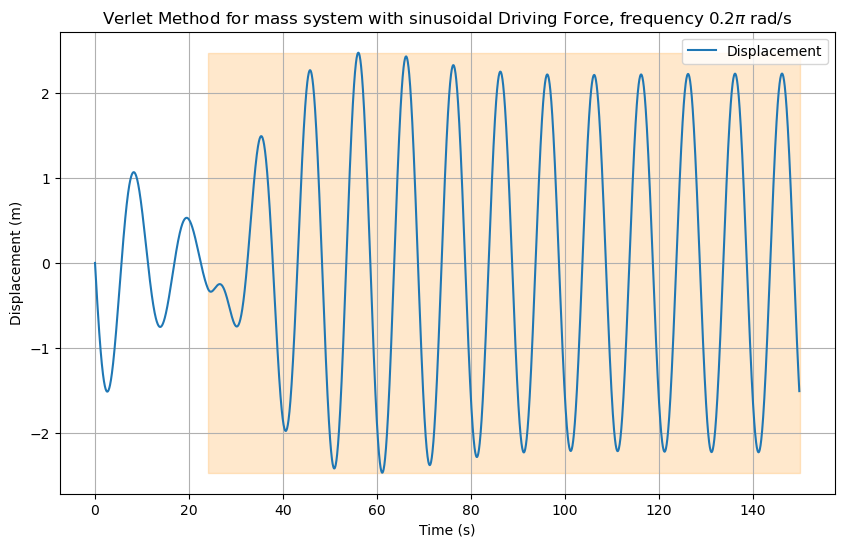

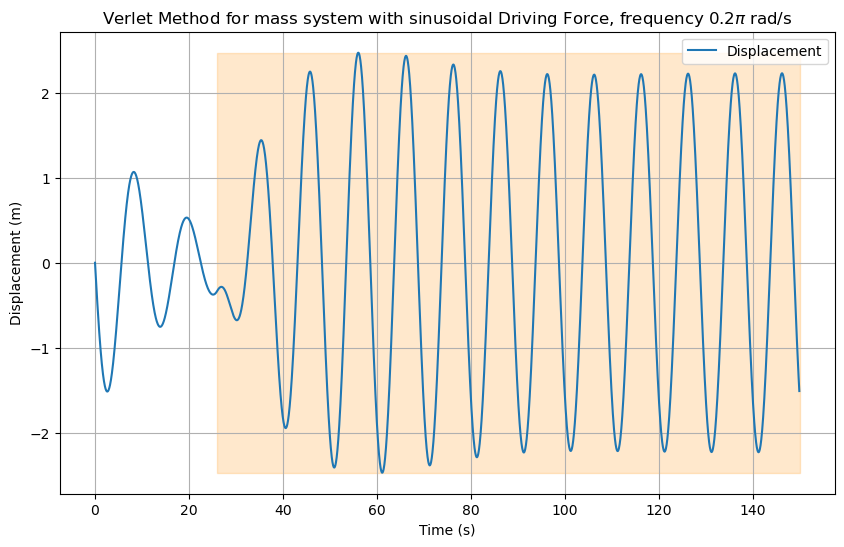

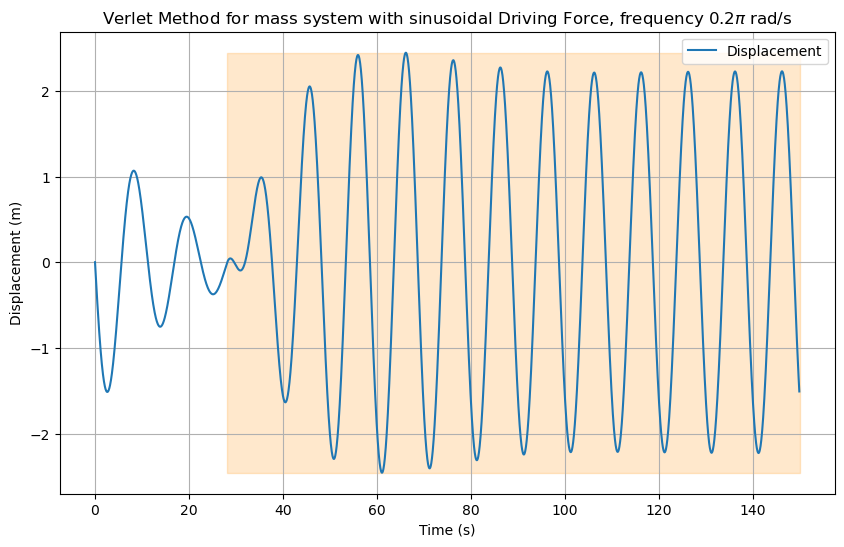

In [19]:
# Create list of time intervals to apply sinusoidal force over - each interval lasts to the end of the total time 
    # to ensure transient effects are exhausted
PUSH_TIMES_LIST = [(20, 150), (22, 150), (24, 150), (26, 150), (28, 150)]
for timeset in PUSH_TIMES_LIST:
    POSITIONS, VELOCITIES = VerletExternalForce(x0, v0, nsteps, h, b, 'sinusoidal', 
                                            timeset[0], timeset[1], 1, (0.2*np.pi))
    plot_driving_force(POSITIONS, VELOCITIES, TIME, h, 'sinusoidal', timeset[0], timeset[1], r'$0.2\pi$')

Again, depending on the point in the cycle that the force is applied at, it either enhances or initially cancels the amplitdue of the displacement. This means that transient effects last longer depending on which point of the oscillation the sinusoidal force is initially applied at. For example, the transient effects have dissipated at just after 80 seconds in the first graph, but take closer to 90 seconds in the fourth graph.

# Investigating resonance

The numerical methods can also be used to investigate resonance properties of the mass-spring system, whereby the amplitude of an oscillating system is amplified when it is subjected to a sinusoidal external force at its natural frequency, $\omega_n$. For a mass-spring system this is determined by the mass and the stiffness of the spring as:

$\omega_n = \sqrt{\frac{k}{m}}$ .

This resonance occurs because at this frequency, the energy provided to the system by the external force is stored in its natural modes of vibration.

The code below models a sinusoidal external force at various angular frequencies above and below the system's natural frequency, and plots them to demonstrate their changing amplitudes (after an initial transient phase).

The natural frequency is 0.561 rad/s to 3 s.f.


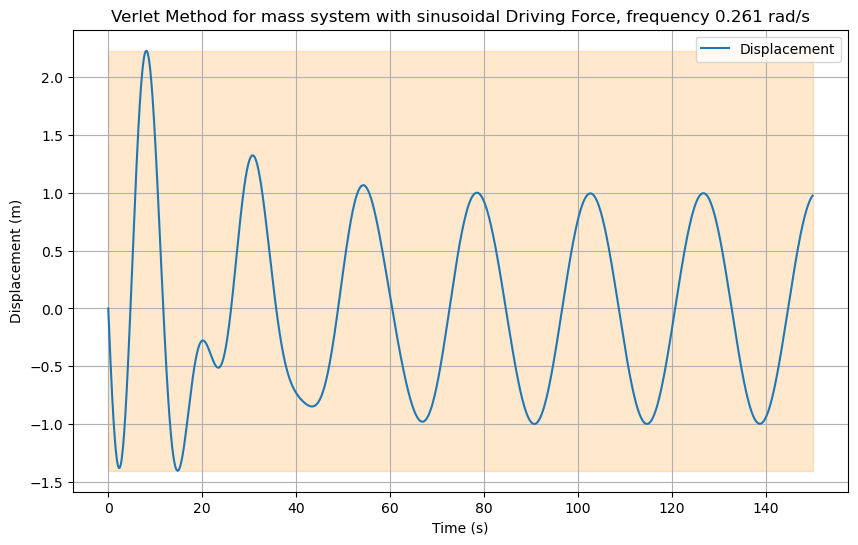

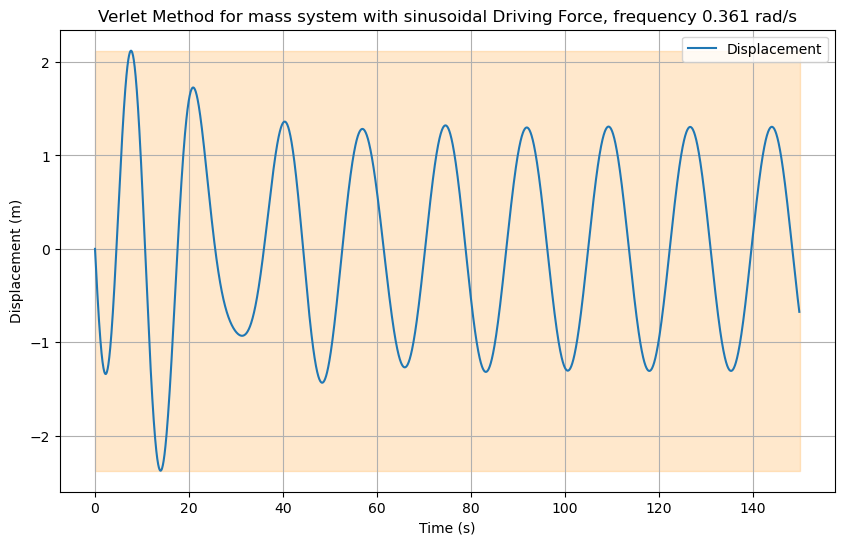

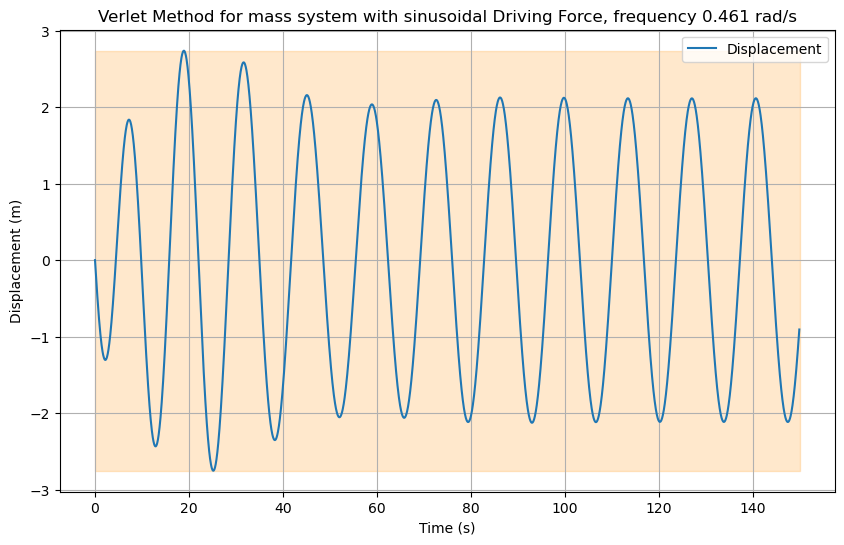

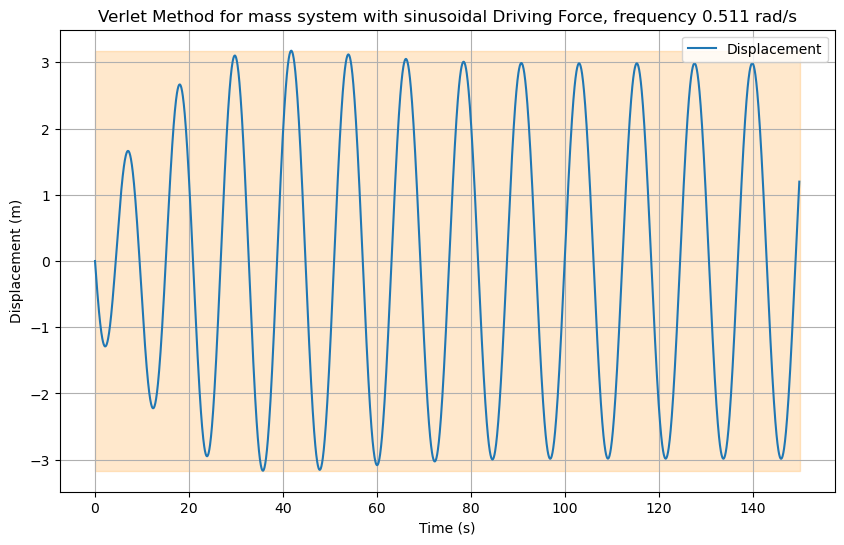

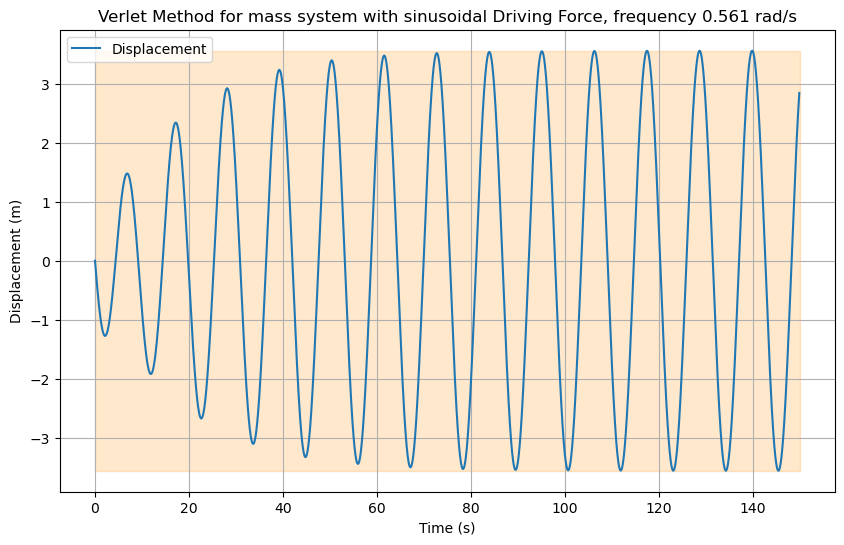

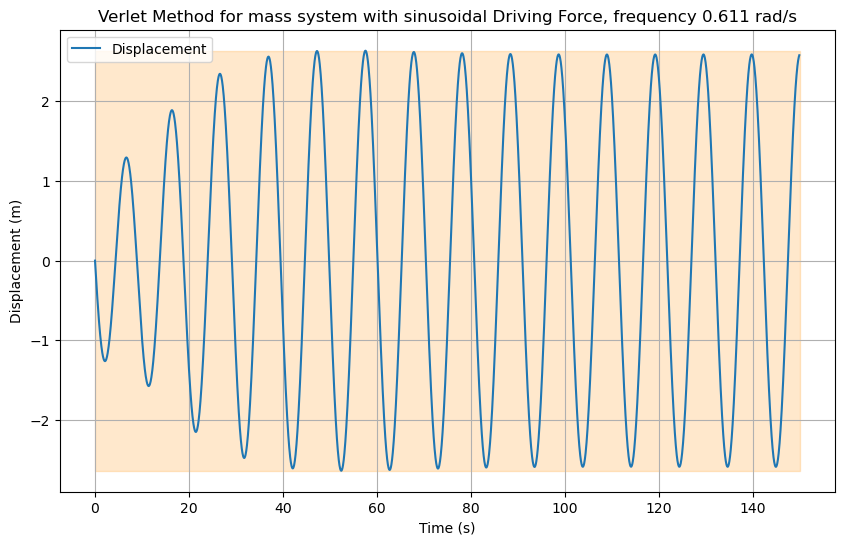

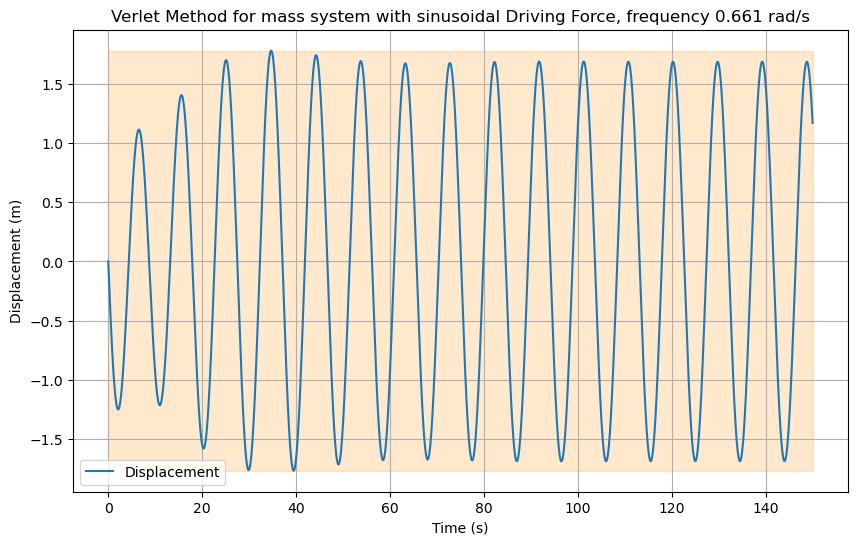

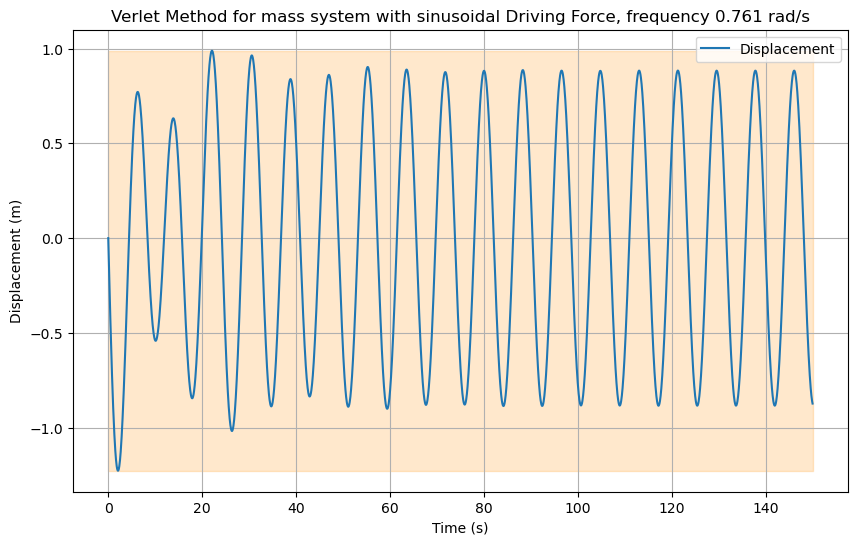

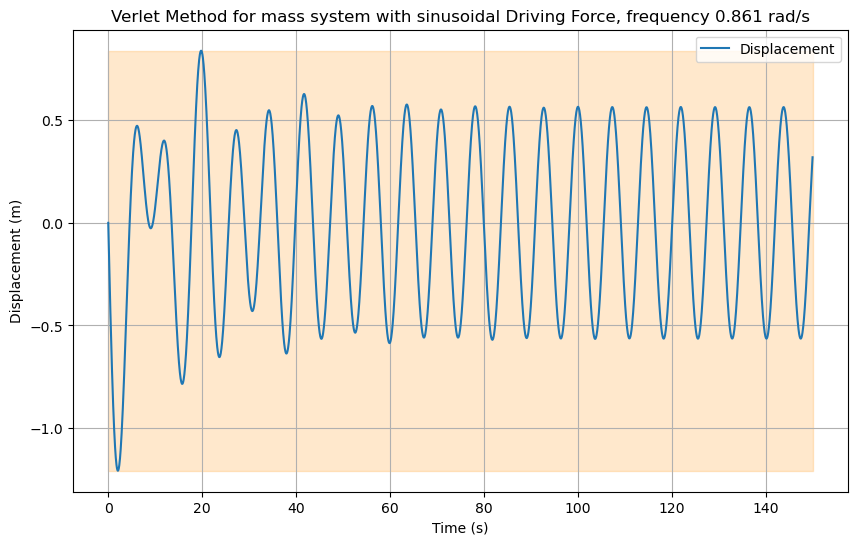

In [20]:
# Values for h and b are the same as set in the previous "push" section

# Calculate the natural frequency
w_n = np.sqrt(k / m)
print('The natural frequency is {:.3f} rad/s to 3 s.f.'.format(w_n))

# Create a list of angular frequencies to apply the sinusoidal external force with around the natural frequency
FREQUENCIES = [(w_n-0.3), (w_n-0.2),(w_n-0.1),(w_n-0.05), w_n, (w_n+0.05), (w_n+0.1), (w_n+0.2), (w_n+0.3)]

# Define function that calculates average amplitude of system after transient effects for each frequency in list
def calc_amplitudes():
    # Create empty list for storing amplitudes
    amplitudes = []
    
    # Iterating through different frequencies to plot positions and find amplitude
    for w in FREQUENCIES:
        POSITIONS = VerletExternalForce(x0, v0, nsteps, h, b, 'sinusoidal', 0, 150, 1, w)[0]
            # Time interval from 0 to 150 seconds to last the whole time
            # Amplitude of external sinusoidal force is 1
        ang_frequency = str(round(w, 3))
        plot_driving_force(POSITIONS, None, TIME, h, 'sinusoidal', 0, 150, ang_frequency)
    
        # Start evaluating peaks/troughs at time = 60 seconds to allow transient effects to die away
        nth_step = int(60 / h)
        non_transient_pos = np.array(POSITIONS[nth_step:])
    
        # Making lists of peaks and troughs
        peaks = []
        troughs = []
        for i in range(1, len(non_transient_pos)-1):
            if non_transient_pos[i-1] <= non_transient_pos[i]:
                if non_transient_pos[i] >= non_transient_pos[i+1]:
                    peaks.append(non_transient_pos[i])
        
            if non_transient_pos[i-1] >= non_transient_pos[i]:
                if non_transient_pos[i] <= non_transient_pos[i+1]:
                    troughs.append(non_transient_pos[i])
        
        # Calculating amplitude
        avg_peak = np.mean(peaks)
        avg_trough = np.mean(troughs)
        amplitudes.append((avg_peak - avg_trough) / 2)
    return amplitudes
    
AMPLITUDES = calc_amplitudes()

Looking at these graphs, the range of the y axes changes depending on the frequency, indicating some resonance property where the amplitude is greater at a certain angular frequency of the forced oscillation. The graph below depicts this more concisely by plotting the average amplitude against the angular frequency.

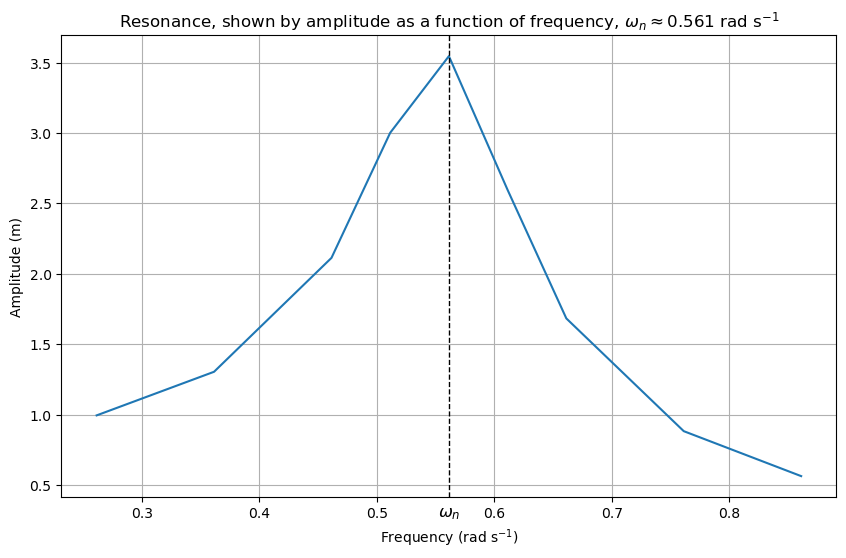

In [21]:
# Plot results for resonance
def plot_resonance(frequencies, amplitudes):    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(frequencies, amplitudes)
    
    # Add dashed line at natural frequency to show where the peak of the graph is 
    ax.axvline(x=w_n, c='black', linestyle='--', linewidth='1')

    ax.set_xlabel(r'Frequency (rad s$^{-1}$)')
    ax.set_ylabel('Amplitude (m)')
    ax.set_title(r'Resonance, shown by amplitude as a function of frequency, $\omega_n\approx 0.561$ rad s$^{-1}$')
    
    # Add extra label on x-axis to label the dashed vertical line as the natural frequency
    ax.text(w_n, 0.3, r'$\omega_n$', fontsize=12, ha='center', va='center')
    ax.grid(True)
    plt.show()
    plt.close
    
plot_resonance(FREQUENCIES, AMPLITUDES)

This clearly shows that the average amplitude of the mass-spring system after an initial transient phase is dependent on the frequency of the external force, and peaks at the natural frequency of the system. Resonance is therefore demonstrated by the system.